# Cryptocurrency Forecasting

## Problem Description

There are many cryptocurrency traders and businesses that deal in and use cryptocurrency, such as banks. For instance, some banks employ cryptocurrency to facilitate speedy transactions, "but because of its volatile pricing and the innovative blockchain technology it uses, they have trouble forecasting and assessing the cryptocurrency [1]". "It is much more difficult to predict the cryptocurrency because it is easily impacted by news about purchases, social media trends, and other cryptocurrencies [3]". Building trustworthy prediction models for cryptocurrency prices is crucial because they offer traders, investors, and banks useful information for successfully navigating the world of digital assets.

## Dataset Description

"The analysis was performed using Cryptocurrency Historical Data from Kaggle by sudalairajkumar [2]". The dataset provided contains historical information about the performance of various cryptocurrencies, including 37,082 entries with 10 columns. Each record includes details such as a serial number (SNo) for each entry of each coin, the name of the cryptocurrency (e.g., Stellar), its symbol (e.g., XLM), and the date and time of the observation in the format YYYY-MM-DD HH:MM:SS. Price-related fields include the highest price (High), lowest price (Low), opening price (Open), and closing price (Close) for the given day. Additionally, it records the trading volume (Volume) and the total market capitalization (Marketcap) for the cryptocurrency on that day. This dataset can help with cryptocurrency price prediction applications.

##Imports

In [1]:
!pip install sktime
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.compose import EnsembleForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_squared_error
from sktime.forecasting.model_selection import SlidingWindowSplitter
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.9/36.9 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.5/141.5 kB 3.9 MB/s eta 0:00:00


## Dataset Overview: including the number of samples, features, etc.

###Downloading The Cryptocurrency Price Dataset From Kaggle

🔍 What This Code Does:

This block downloads a dataset of historical cryptocurrency prices from Kaggle using the kagglehub package, loads all .csv files in that dataset folder, and combines them into a single pandas DataFrame. The result is a unified dataset that includes price data for multiple cryptocurrencies.

In [2]:
# 📥 Download the latest version of the dataset from Kaggle
path = kagglehub.dataset_download("sudalairajkumar/cryptocurrencypricehistory")
print("Path to dataset files:", path)

# 📂 List all the files in the downloaded dataset directory
files = os.listdir(path)
print("Files in dataset:", files)

# 📋 Initialize an empty list to store individual DataFrames
dataframes = []

# 🔁 Loop through each file in the directory
for file_to_load in files:
    file_path = os.path.join(path, file_to_load)

    # ✅ Only process files that end with .csv (skip other formats)
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)  # Load the CSV into a DataFrame
        dataframes.append(df)        # Add it to the list of DataFrames

# 🧩 Combine all loaded DataFrames into a single DataFrame
df = pd.concat(dataframes, ignore_index=True)


100%|██████████| 1.70M/1.70M [00:00<00:00, 2.22MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sudalairajkumar/cryptocurrencypricehistory/versions/3
Files in dataset: ['coin_EOS.csv', 'coin_XRP.csv', 'coin_Uniswap.csv', 'coin_ChainLink.csv', 'coin_Ethereum.csv', 'coin_Litecoin.csv', 'coin_Tron.csv', 'coin_Cardano.csv', 'coin_BinanceCoin.csv', 'coin_Bitcoin.csv', 'coin_Dogecoin.csv', 'coin_Cosmos.csv', 'coin_Iota.csv', 'coin_NEM.csv', 'coin_Tether.csv', 'coin_Monero.csv', 'coin_Stellar.csv', 'coin_USDCoin.csv', 'coin_Aave.csv', 'coin_WrappedBitcoin.csv', 'coin_Polkadot.csv', 'coin_CryptocomCoin.csv', 'coin_Solana.csv']


###Previewing the Combined Dataset

🔍 What This Code Does:

This block displays the first five rows of the merged cryptocurrency dataset using df.head(). This is a quick way to check the structure, columns, and sample values of the data before further analysis.

In [3]:
# 👁️ Display the first 5 rows of the DataFrame to get an overview of the data structure and content
df.head()

SNo Name Symbol                 Date     High       Low      Open    Close  \
0    1  EOS    EOS  2017-07-02 23:59:59  2.87751  0.822648  0.996521  2.71005   
1    2  EOS    EOS  2017-07-03 23:59:59  5.39597  2.632310  2.717390  4.08664   
2    3  EOS    EOS  2017-07-04 23:59:59  4.19124  2.933450  4.098010  3.37200   
3    4  EOS    EOS  2017-07-05 23:59:59  3.52350  2.730130  3.356000  3.00323   
4    5  EOS    EOS  2017-07-06 23:59:59  3.86747  3.007830  3.014260  3.36133   

        Volume     Marketcap  
0  320452000.0  0.000000e+00  
1  414950016.0  6.549307e+08  
2  218559008.0  5.501552e+08  
3  124339000.0  5.006264e+08  
4  177463008.0  5.683615e+08

###Displaying the Entire Dataset

In [4]:
# 🧾 Displaying the whole DataFrame — shows all rows and columns in the dataset
df

SNo    Name Symbol                 Date       High        Low  \
0        1     EOS    EOS  2017-07-02 23:59:59   2.877510   0.822648   
1        2     EOS    EOS  2017-07-03 23:59:59   5.395970   2.632310   
2        3     EOS    EOS  2017-07-04 23:59:59   4.191240   2.933450   
3        4     EOS    EOS  2017-07-05 23:59:59   3.523500   2.730130   
4        5     EOS    EOS  2017-07-06 23:59:59   3.867470   3.007830   
...    ...     ...    ...                  ...        ...        ...   
37077  448  Solana    SOL  2021-07-02 23:59:59  34.031786  31.479924   
37078  449  Solana    SOL  2021-07-03 23:59:59  35.404770  33.298475   
37079  450  Solana    SOL  2021-07-04 23:59:59  35.502372  33.555737   
37080  451  Solana    SOL  2021-07-05 23:59:59  34.461824  32.482692   
37081  452  Solana    SOL  2021-07-06 23:59:59  34.978319  32.930307   

            Open      Close        Volume     Marketcap  
0       0.996521   2.710050  3.204520e+08  0.000000e+00  
1       2.717390   4.086640  4.149500e+08  6.549307e+08  
2       4.098010   3.372000  2.185590e+08  5.501552e+08  
3       3.356000   3.003230  1.243390e+08  5.006264e+08  
4       3.014260   3.361330  1.774630e+08  5.683615e+08  
...          ...        ...           ...           ...  
37077  33.306310  34.020482  4.402988e+08  9.275257e+09  
37078  34.015575  34.478816  3.270200e+08  9.400216e+09  
37079  34.495117  34.310601  3.034205e+08  9.354354e+09  
37080  34.282550  32.984588  3.138393e+08  8.992833e+09  
37081  32.930307  34.269140  3.653360e+08  9.343050e+09  

[37082 rows x 10 columns]

##Data Cleaning

###Selecting Relevant Columns and Formatting Dates

🔍 What This Code Does:

Removing unnecessary columns like (SNo, High, Low and Open) and fixing the date by making it datetime without hours for consistency in time-based analysis.

In [5]:
# 📊 Select specific columns from the DataFrame for focused analysis
df = df[['Name','Symbol','Date','Close','Volume','Marketcap']]  # Keep only relevant financial and identifier columns

# 📅 Convert the 'Date' column to datetime format and normalize (removes time info, keeps date only)
df['Date'] = pd.to_datetime(df['Date']).dt.normalize()

# 👁️ Display the updated DataFrame with selected columns and formatted date
df

<ipython-input-5-53bdcca987e6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date']).dt.normalize()


Name Symbol       Date      Close        Volume     Marketcap
0         EOS    EOS 2017-07-02   2.710050  3.204520e+08  0.000000e+00
1         EOS    EOS 2017-07-03   4.086640  4.149500e+08  6.549307e+08
2         EOS    EOS 2017-07-04   3.372000  2.185590e+08  5.501552e+08
3         EOS    EOS 2017-07-05   3.003230  1.243390e+08  5.006264e+08
4         EOS    EOS 2017-07-06   3.361330  1.774630e+08  5.683615e+08
...       ...    ...        ...        ...           ...           ...
37077  Solana    SOL 2021-07-02  34.020482  4.402988e+08  9.275257e+09
37078  Solana    SOL 2021-07-03  34.478816  3.270200e+08  9.400216e+09
37079  Solana    SOL 2021-07-04  34.310601  3.034205e+08  9.354354e+09
37080  Solana    SOL 2021-07-05  32.984588  3.138393e+08  8.992833e+09
37081  Solana    SOL 2021-07-06  34.269140  3.653360e+08  9.343050e+09

[37082 rows x 6 columns]

###Inspecting DataFrame Structure and Data Quality


🔍 What This Code Does:

This block uses .info() to display a summary of the DataFrame. It includes details about each column’s data type, the number of non-null values, and memory usage. This is helpful for identifying potential data quality issues such as missing values or incorrect formats.

In [6]:
# 📋 Summary of the DataFrame — shows column names, data types, non-null values, and memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37082 entries, 0 to 37081
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Name       37082 non-null  object        
 1   Symbol     37082 non-null  object        
 2   Date       37082 non-null  datetime64[ns]
 3   Close      37082 non-null  float64       
 4   Volume     37082 non-null  float64       
 5   Marketcap  37082 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 1.7+ MB


###Checking for Missing Values in the Dataset

🔍 What This Code Does:

This block identifies and reports any missing values in the dataset. It calculates the total number of NaN (null) entries in each column and prints the results. This is a crucial step before performing data cleaning or modeling

In [7]:
# ✅ Check for missing values in the dataset

# 🧮 Calculate the total number of missing (NaN) values for each column in the DataFrame
missing_counts = df.isnull().sum()

# 🖨️ Print a summary showing how many missing values exist in each column
print("Missing values in each column:")
missing_counts

Missing values in each column:


Name         0
Symbol       0
Date         0
Close        0
Volume       0
Marketcap    0
dtype: int64

###Filtering Dataset for Top 5 Cryptocurrencies

🔍 What This Code Does:

This block filters the original dataset to retain only the rows corresponding to five selected cryptocurrencies: **Bitcoin, XRP, Litecoin, Monero, and Dogecoin**. After filtering, the index is reset for cleaner display and further processing.

In [8]:
# 🧮 Filter the DataFrame to include only rows where the 'Name' column matches one of the specified cryptocurrency names
top5 = df[(df['Name'] == 'Bitcoin') |  # ✅ Include rows where the name is 'Bitcoin'
          (df['Name'] == 'XRP') |
          (df['Name'] == 'Litecoin') |
          (df['Name'] == 'Monero') |
          (df['Name'] == 'Dogecoin')]

# 🔄 Reset the index of the filtered DataFrame to maintain order and readability
top5 = top5.reset_index(drop=True)

# 👁️ Display the filtered DataFrame containing data for the top five cryptocurrencies
top5

Name Symbol       Date       Close        Volume     Marketcap
0         XRP    XRP 2013-08-05    0.005613  0.000000e+00  4.387916e+07
1         XRP    XRP 2013-08-06    0.004680  0.000000e+00  3.659101e+07
2         XRP    XRP 2013-08-07    0.004417  0.000000e+00  3.453412e+07
3         XRP    XRP 2013-08-08    0.004254  0.000000e+00  3.325863e+07
4         XRP    XRP 2013-08-09    0.004291  0.000000e+00  3.354750e+07
...       ...    ...        ...         ...           ...           ...
14232  Monero    XMR 2021-07-02  211.345143  1.519434e+08  3.792466e+09
14233  Monero    XMR 2021-07-03  214.752778  1.364141e+08  3.853768e+09
14234  Monero    XMR 2021-07-04  219.841418  1.697858e+08  3.945232e+09
14235  Monero    XMR 2021-07-05  214.464993  1.709852e+08  3.848898e+09
14236  Monero    XMR 2021-07-06  222.137136  1.678620e+08  3.986738e+09

[14237 rows x 6 columns]

##Exploratory Data Analysis (EDA) of Top Cryptocurrencies

###Exploring Observation Counts per Cryptocurrency

🔍 What This Code Does:

This block performs exploratory analysis to understand how many data points exist for each of the top 5 cryptocurrencies in the filtered dataset. It calculates the number of unique cryptocurrencies, visualizes their frequency using a bar chart, and prints exact observation counts for each one.

Number of cryptocurrencies: 5


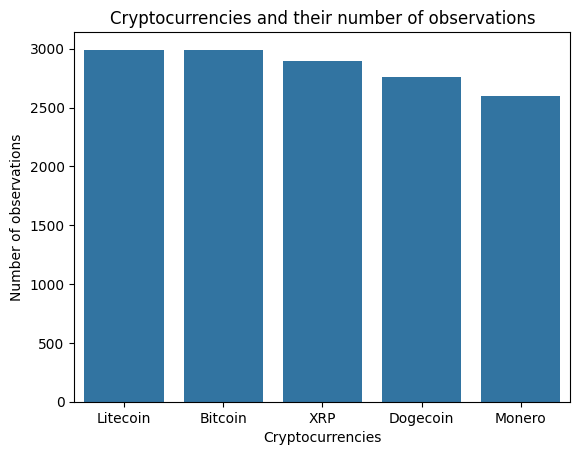

Name
Litecoin    2991
Bitcoin     2991
XRP         2893
Dogecoin    2760
Monero      2602


In [9]:
# 🔢 Calculate the number of unique cryptocurrency names in the filtered DataFrame
number_of_cryptocurrencies = top5['Name'].nunique()
print(f"Number of cryptocurrencies: {number_of_cryptocurrencies}")  # 🖨️ Print how many unique names exist

# 📊 Create a count plot to visualize the number of observations per cryptocurrency
sns.countplot(x='Name', data=top5, order=top5['Name'].value_counts().index)

# 🏷️ Add a title and axis labels for clarity
plt.title('Cryptocurrencies and their number of observations')
plt.xlabel('Cryptocurrencies')
plt.ylabel('Number of observations')

# 👁️ Display the bar plot
plt.show()

# 🧮 Calculate and print the number of rows (observations) available for each cryptocurrency
number_of_cryptocurrencies = top5['Name'].value_counts()
print(number_of_cryptocurrencies.to_string())


###Descriptive Statistics for Top Cryptocurrencies

🔍 What This Code Does:

This block calculates key summary statistics — **mean, minimum, and maximum** — for three financial metrics: Close, Volume, and Marketcap, grouped by each of the five selected cryptocurrencies. This helps in understanding the average performance, variability, and scale of each asset.

In [10]:
# 📊 Calculate the mean of 'Close', 'Volume', and 'Marketcap' for each cryptocurrency
avg = top5[['Name','Close','Volume','Marketcap']].groupby('Name').mean()

# 🔽 Calculate the minimum values for each metric per cryptocurrency
min = top5[['Name','Close','Volume','Marketcap']].groupby('Name').min()

# 🔼 Calculate the maximum values for each metric per cryptocurrency
max = top5[['Name','Close','Volume','Marketcap']].groupby('Name').max()

# 🖨️ Print the calculated mean, minimum, and maximum values for each cryptocurrency
print("Average:")
print(avg)

print("\nMin:")
print(min)

print("\nMax:")
print(max)


Average:
                Close        Volume     Marketcap
Name                                             
Bitcoin   6711.290443  1.090633e+10  1.208761e+11
Dogecoin     0.013763  4.326321e+08  1.760533e+09
Litecoin    49.279008  1.284851e+09  2.934139e+09
Monero      74.134773  1.637467e+08  1.236534e+09
XRP          0.234790  1.260299e+09  9.678507e+09

Min:
              Close       Volume     Marketcap
Name                                          
Bitcoin   68.431000     0.000000  7.784112e+08
Dogecoin   0.000087     0.000000  1.509085e+06
Litecoin   1.157010     0.000000  3.789242e+07
Monero     0.223522  7899.569824  1.279606e+06
XRP        0.002810     0.000000  2.196991e+07

Max:
                 Close        Volume     Marketcap
Name                                              
Bitcoin   63503.457930  3.509679e+11  1.186364e+12
Dogecoin      0.684777  6.941068e+10  8.868082e+10
Litecoin    386.450779  1.799426e+10  2.579652e+10
Monero      483.583612  2.895912e+10  8.65896

###Visualizing Market Capitalization of Top Cryptocurrencies

🔍 What This Code Does:

This block creates a horizontal bar chart to visualize the **market capitalization** of the selected cryptocurrencies. The cryptocurrencies are sorted in descending order based on market cap, and the chart provides a clear comparison of their financial scale.

<ipython-input-11-a434f1d55205>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=sorted_names, x=market_caps[sorted_names.index], palette='rocket', edgecolor='black')


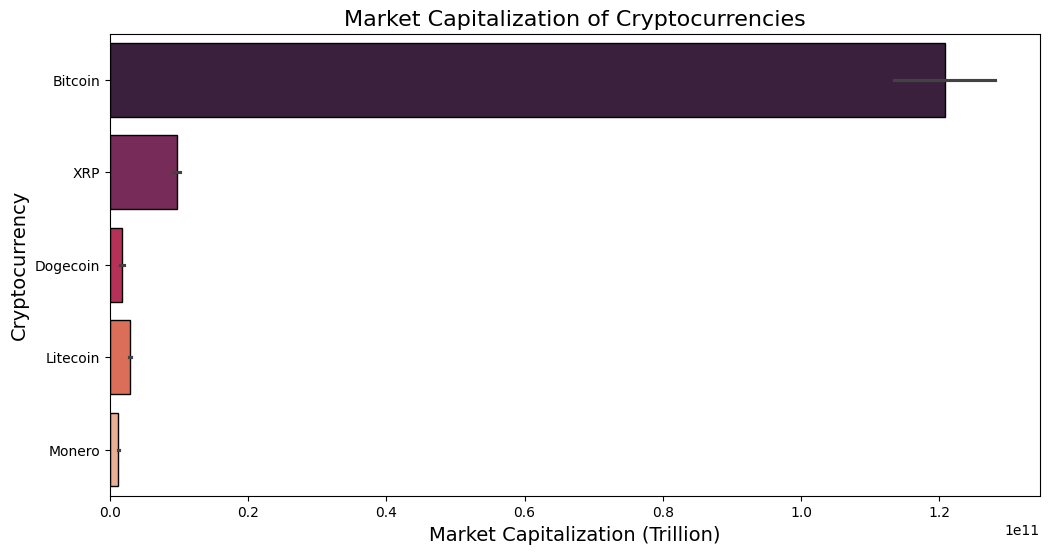

In [11]:
# 💰 Use the raw market cap values (assumed to already be in billions or trillions)
market_caps = top5['Marketcap']
names = top5['Name']

# 🔽 Sort cryptocurrencies by market cap in descending order
sorted_names = top5.sort_values(by='Marketcap', ascending=False)['Name']

# 🖼️ Set the size of the figure and visual style
plt.figure(figsize=(12, 6))

# 📊 Create a horizontal bar plot of market cap by cryptocurrency
ax = sns.barplot(y=sorted_names, x=market_caps[sorted_names.index], palette='rocket', edgecolor='black')

# 🏷️ Set axis labels and title for clarity
plt.xlabel('Market Capitalization (Trillion)', fontsize=14)
plt.ylabel('Cryptocurrency', fontsize=14)
plt.title('Market Capitalization of Cryptocurrencies', fontsize=16)

# 👁️ Display the plot
plt.show()


###Visualizing Cryptocurrency Price Trends Over Time

🔍 What This Code Does:

This block creates a series of subplots to visualize how the **closing price** of each top cryptocurrency changes over time. Each subplot represents one cryptocurrency, with time on the x-axis and closing price on the y-axis. The x-axis is formatted to show only years, improving readability across multiple time periods.

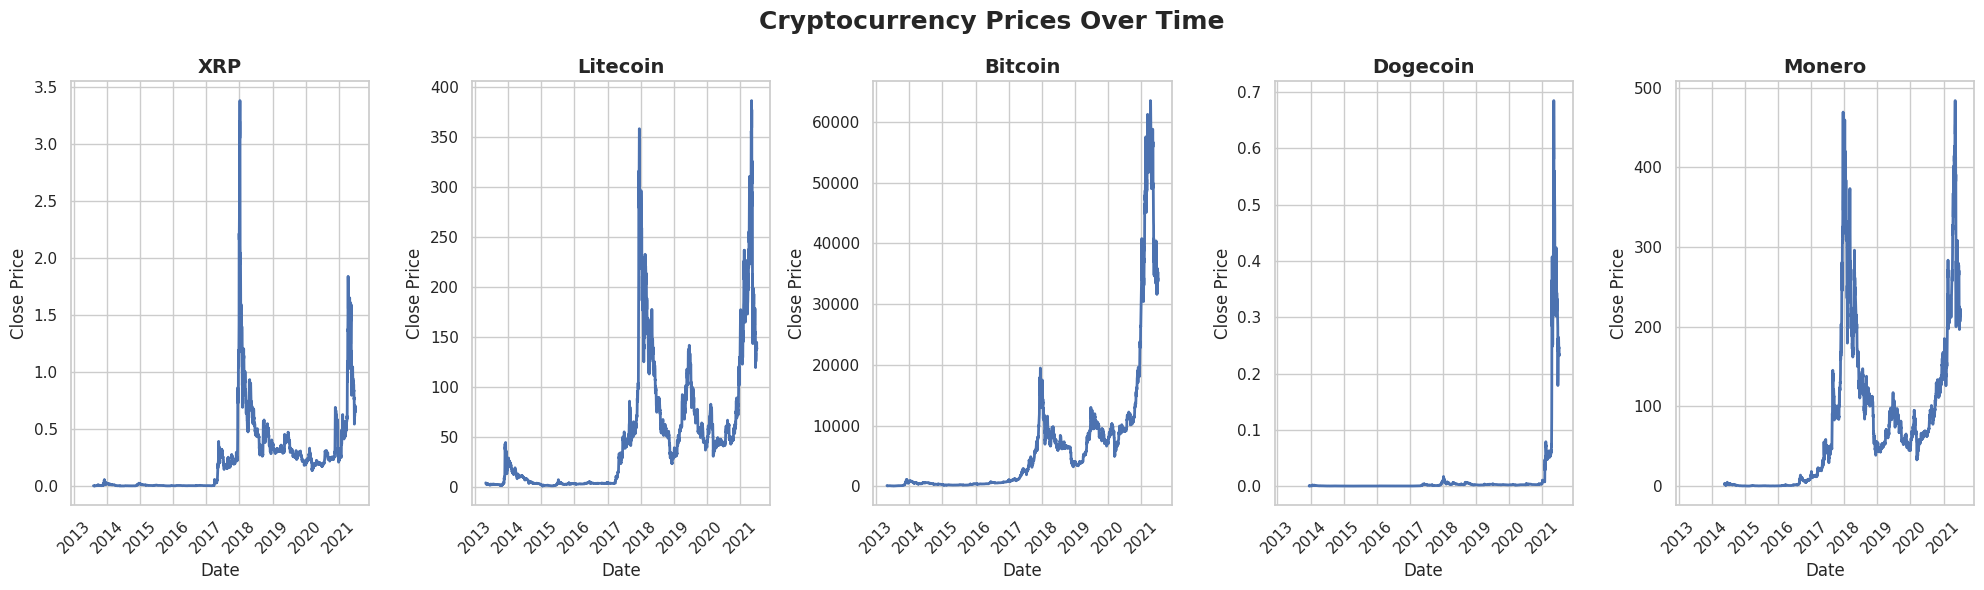

In [12]:
# 🎨 Set a clean and readable style for all seaborn plots
sns.set(style="whitegrid")

# 🪙 Get the list of unique cryptocurrency names
coins = top5['Name'].unique()
num_coins = len(coins)

# 🖼️ Create a subplot layout: one row with as many columns as coins
fig, axes = plt.subplots(1, num_coins, figsize=(20, 6), sharex=True)

# 🛠️ If there's only one coin, wrap the single axis in a list to standardize handling
if num_coins == 1:
    axes = [axes]

# 🔁 Loop through each cryptocurrency to plot its price trend
for i, coin in enumerate(coins):
    ax = axes[i]  # Select the subplot for the current coin
    coin_data = top5[top5['Name'] == coin].copy()  # 🔎 Filter data for this coin

    # 🗓️ Ensure the 'Date' column is in datetime format and set it as index
    coin_data['Date'] = pd.to_datetime(coin_data['Date'])
    coin_data.set_index('Date', inplace=True)

    # 📈 Plot the closing price over time
    ax.plot(coin_data.index, coin_data['Close'], label=coin, color='b', lw=2)

    # 🏷️ Add title and labels to the individual subplot
    ax.set_title(coin, fontsize=14, fontweight="bold")
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Close Price", fontsize=12)

    # 📅 Format the x-axis to show only years
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=45)

# 🧢 Add a main title for the entire plot grid
plt.suptitle("Cryptocurrency Prices Over Time", fontsize=18, fontweight="bold")
plt.tight_layout()  # 🧱 Optimize spacing between subplots
plt.show()


### Analyzing Daily Price Volatility of Cryptocurrencies

🔍 What This Code Does:

This block calculates the **daily percentage change** in closing prices for each cryptocurrency to measure short-term price movements. It then:

* Computes the **overall volatility** (standard deviation of daily changes) for each coin and visualizes it using a bar plot.

* Plots a **time series line chart** showing how daily changes fluctuate over time, helping detect patterns or sudden spikes in volatility.




<ipython-input-13-d7c5cb37f9c6>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=volatility, x="Name", y="Volatility", palette="viridis")


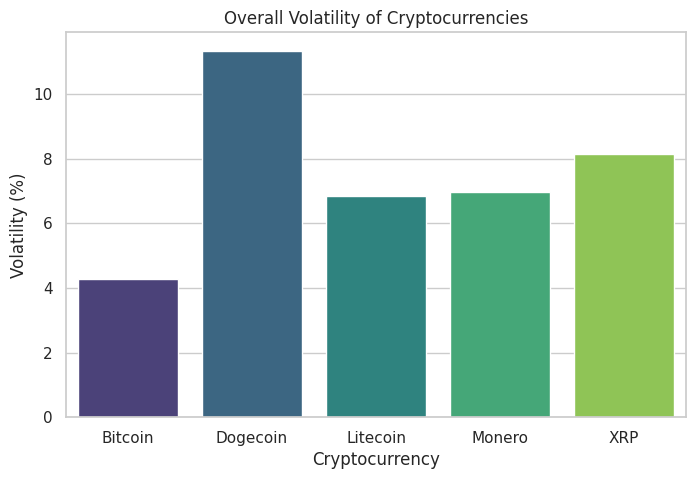

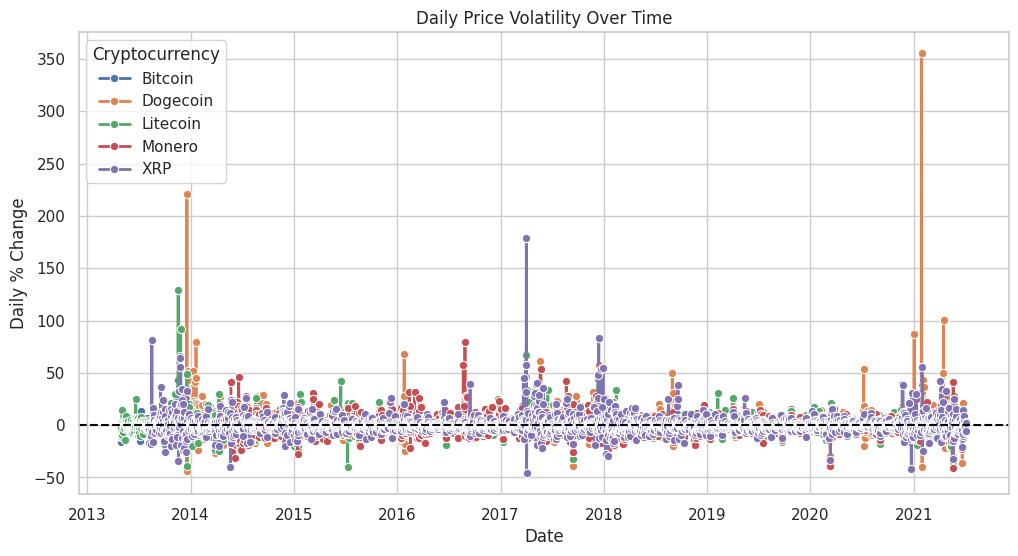

In [13]:
# 📊 Sort the data by cryptocurrency name and date for accurate time-series calculations
df = top5.sort_values(by=["Name", "Date"])

# 🔁 Calculate the daily percentage change in closing price for each cryptocurrency
df["Daily_Change"] = df.groupby("Name")["Close"].pct_change() * 100

# 📉 Compute volatility as the standard deviation of daily changes for each coin
volatility = df.groupby("Name")["Daily_Change"].std().reset_index()
volatility.columns = ["Name", "Volatility"]

# 📊 Create a bar plot to visualize volatility for each cryptocurrency
plt.figure(figsize=(8, 5))
sns.barplot(data=volatility, x="Name", y="Volatility", palette="viridis")
plt.xlabel("Cryptocurrency")
plt.ylabel("Volatility (%)")
plt.title("Overall Volatility of Cryptocurrencies")
plt.show()

# 📈 Create a time series line plot to show daily price changes over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="Date", y="Daily_Change", hue="Name", marker="o", linewidth=2)

# ➖ Add a horizontal reference line at 0% change
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Daily % Change")
plt.title("Daily Price Volatility Over Time")
plt.legend(title="Cryptocurrency")
plt.grid(True)
plt.show()


##Correlation Analysis and Data Scaling,

###Correlation Analysis Between Financial Metrics

🔍 What This Code Does:

This block performs a **correlation analysis** between the numerical features (Close, Volume, and Marketcap) of the top 5 cryptocurrencies. It computes the correlation matrix and visualizes the relationships using a heatmap to identify how strongly these financial variables are related to each other.

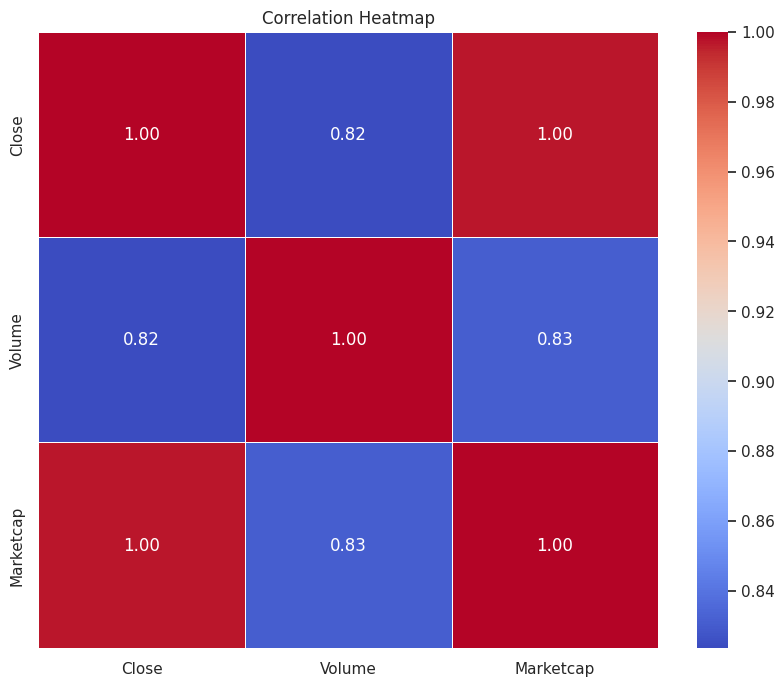

In [14]:
# 🧹 Drop non-numeric columns to focus only on numerical features for correlation analysis
cdf = top5.drop(columns=['Name', 'Symbol','Date'])

# 🔗 Compute the correlation matrix between 'Close', 'Volume', and 'Marketcap'
corr_matrix = cdf.corr()

# 🔥 Plot a heatmap to visualize the strength and direction of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


###Exploring the Relationship Between Closing Price and Market Capitalization

🔍 What This Code Does:

This block creates a **scatter plot** to visualize the relationship between the closing price and market capitalization of the top 5 cryptocurrencies. Each point represents a single data entry, with color intensity reflecting the magnitude of market cap. This helps identify trends, clustering, or outliers between price and value.

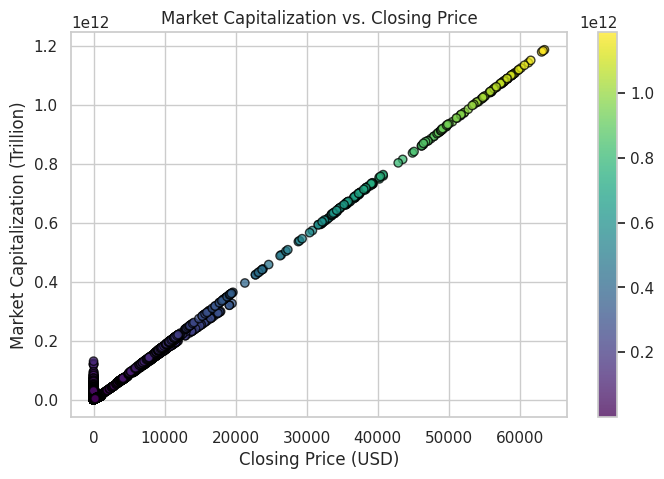

In [15]:
# 📊 Extract relevant numeric columns for plotting
closing_prices = top5["Close"]
market_caps = top5["Marketcap"]

# 🎯 Create a scatter plot where color intensity is based on market cap
plt.figure(figsize=(8, 5))
plt.scatter(closing_prices, market_caps, c=market_caps, cmap="viridis", alpha=0.75, edgecolors="black")

# 🎨 Add a color bar for reference
cbar = plt.colorbar()

# 🏷️ Add labels and a title for context
plt.xlabel("Closing Price (USD)")
plt.ylabel("Market Capitalization (Trillion)")
plt.title("Market Capitalization vs. Closing Price")
plt.grid(True)

# 👁️ Display the scatter plot
plt.show()


###Applying Scaling Techniques and Visualize The Impacts

🔍 What This Code Does:

This block prepares the data for machine learning and statistical modeling by performing feature extraction and **data scaling**. It extracts time-based features from the Date column (Year, Month, Day) and applies two common normalization techniques—**Min-Max Scaling** and **Standardization** (Z-score). It then visualizes how these transformations affect the distribution of the first two numeric features (Close and Volume) using scatter plots.

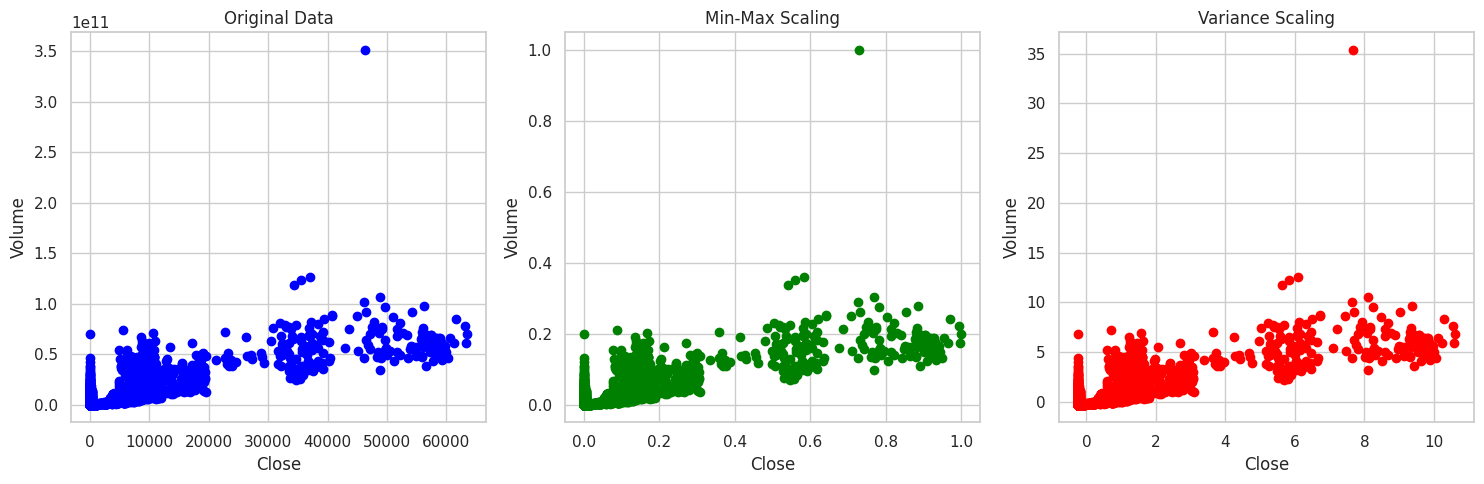

In [16]:
data = top5.copy()

# 📅 Convert 'Date' to datetime format and extract year, month, and day as new features
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

# ❌ Drop the original 'Date' column since it's no longer needed
data = data.drop(columns=['Date'])

# 🔢 Define the list of numeric columns to be scaled
numerical_cols = ['Close', 'Volume', 'Marketcap', 'Year', 'Month', 'Day']

# 🔄 Apply Min-Max Scaling to normalize values between 0 and 1
scaler_minmax = MinMaxScaler()
data_minmax = scaler_minmax.fit_transform(data[numerical_cols])

# 📉 Alternatively, apply Standardization to center data (mean = 0, std = 1)
scaler_standard = StandardScaler()
data_std = scaler_standard.fit_transform(data[numerical_cols])

# 📋 Convert the scaled arrays back into DataFrames for easier handling and visualization
df_minmax = pd.DataFrame(data_minmax, columns=numerical_cols)
df_std = pd.DataFrame(data_std, columns=numerical_cols)

# 🎯 Prepare data for plotting — select the first two features (e.g., 'Close' and 'Volume')
original_data = data[numerical_cols].iloc[:, :2].values
minmax_scaled_data = df_minmax.iloc[:, :2].values
standardized_data = df_std.iloc[:, :2].values

# 📊 Create a figure with 3 subplots to compare scaling techniques
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 📈 Original (unscaled) data plot
axes[0].scatter(original_data[:, 0], original_data[:, 1], c='blue', label="Original Data")
axes[0].set_title("Original Data")
axes[0].set_xlabel(numerical_cols[0])  # 'Close'
axes[0].set_ylabel(numerical_cols[1])  # 'Volume'

# 📈 Min-Max scaled data plot
axes[1].scatter(minmax_scaled_data[:, 0], minmax_scaled_data[:, 1], c='green', label="Min-Max Scaled")
axes[1].set_title("Min-Max Scaling")
axes[1].set_xlabel(numerical_cols[0])
axes[1].set_ylabel(numerical_cols[1])

# 📈 Standardized data plot
axes[2].scatter(standardized_data[:, 0], standardized_data[:, 1], c='red', label="Standardized")
axes[2].set_title("Variance Scaling")
axes[2].set_xlabel(numerical_cols[0])
axes[2].set_ylabel(numerical_cols[1])

# 🎯 Optimize spacing and render all plots
plt.tight_layout()
plt.show()


###Making Visualizations Interactive with Plotly

🔍 What This Code Does:

This block defines a reusable function for generating interactive 2D scatter plots. It then applies this function to both the Min-Max scaled and Standardized versions of the dataset to explore how the scaling affects clustering or distribution. The plots are enhanced with hover tooltips and color gradients based on the Close price, enabling better insight into the data structure.

In [17]:
# 🔧 Define a reusable function for plotting 2D dimensionality reduction results
def create_interactive_dr_plot(data, method_name, color_values=None, hover_data=None):
    if hover_data is None:
        hover_data = {}

    # 📋 Create a DataFrame with two components (e.g., PCA1 and PCA2)
    df_plot = pd.DataFrame(
        data,
        columns=[f'{method_name}1', f'{method_name}2']
    )

    # 🎨 Add coloring and tooltip data if provided
    if color_values is not None:
        df_plot['Color'] = color_values
    for k, v in hover_data.items():
        df_plot[k] = v

    # 🖼️ Create interactive scatter plot with Plotly
    fig = px.scatter(
        df_plot,
        x=f'{method_name}1',
        y=f'{method_name}2',
        color='Color' if color_values is not None else None,
        title=f'{method_name} Visualization',
        labels={f'{method_name}1': f'First {method_name} Component',
                f'{method_name}2': f'Second {method_name} Component'},
        hover_data=list(hover_data.keys()) if hover_data else None
    )

    # 🧱 Adjust layout for better viewing experience
    fig.update_layout(
        width=800,
        height=600,
        margin=dict(l=40, r=40, t=40, b=40)
    )

    return fig

# 🧾 Specify extra information to show when hovering over points in the plot
hover_data = {
    'Close': data['Close'],
    'Volume': data['Volume']
}

# 📉 Create and display the interactive plot for Min-Max scaled data
minmax_plot = create_interactive_dr_plot(
    minmax_scaled_data, 'Min-Max Scaling',
    color_values=data['Close'],  # 🟡 Color points by their closing price
    hover_data=hover_data
)
minmax_plot.show()

# 📊 Create and display the interactive plot for Standardized data
standardized_plot = create_interactive_dr_plot(
    standardized_data, 'Standardized Data',
    color_values=data['Close'],  # 🟠 Color points by their closing price
    hover_data=hover_data
)
standardized_plot.show()


##Preparing for Machine Learing

###Preparing Bitcoin-Specific Dataset for Forecasting

🔍 What This Code Does:

This block filters the dataset to isolate only the data for **Bitcoin (BTC)** and prepares it for time series forecasting. It sets the Date column as the index and renames the Close column to target, which is a common convention for the variable we intend to predict.

In [18]:
# 🧽 Make a copy of the top5 dataset to avoid modifying the original
df = top5.copy()

# 🔎 Filter the dataset to include only rows where the cryptocurrency symbol is 'BTC' (Bitcoin)
df = df[df["Symbol"] == "BTC"]

# 🗓️ Set 'Date' as the index for time series operations
df.set_index('Date', inplace=True)

# 📁 Create a copy of the filtered Bitcoin dataset for further use
btc_df = df.copy()

# 🎯 Rename the 'Close' column to 'target' to mark it as the forecasting target variable
btc_df.rename(columns={'Close': 'target'}, inplace=True)

# 👁️ Display the prepared Bitcoin DataFrame
btc_df


Name Symbol        target        Volume     Marketcap
Date                                                                
2013-04-29  Bitcoin    BTC    144.539993  0.000000e+00  1.603769e+09
2013-04-30  Bitcoin    BTC    139.000000  0.000000e+00  1.542813e+09
2013-05-01  Bitcoin    BTC    116.989998  0.000000e+00  1.298955e+09
2013-05-02  Bitcoin    BTC    105.209999  0.000000e+00  1.168517e+09
2013-05-03  Bitcoin    BTC     97.750000  0.000000e+00  1.085995e+09
...             ...    ...           ...           ...           ...
2021-07-02  Bitcoin    BTC  33897.048590  3.872897e+10  6.354508e+11
2021-07-03  Bitcoin    BTC  34668.548402  2.438396e+10  6.499397e+11
2021-07-04  Bitcoin    BTC  35287.779766  2.492431e+10  6.615748e+11
2021-07-05  Bitcoin    BTC  33746.002456  2.672155e+10  6.326962e+11
2021-07-06  Bitcoin    BTC  34235.193451  2.650126e+10  6.418992e+11

[2991 rows x 5 columns]

###Plotting the Autocorrelation Function (ACF) for Bitcoin Prices

🔍 What This Code Does:

This block defines and calls a function to generate a traditional **Autocorrelation Function (ACF)** plot for Bitcoin’s closing price (now labeled as target). The ACF helps identify how past values influence future values over a range of time lags, which is essential for understanding dependencies and patterns in time series data.

<Figure size 1200x600 with 0 Axes>

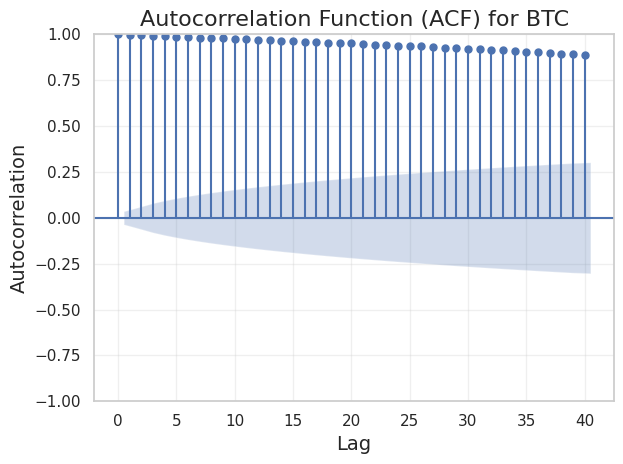

In [19]:
# 📈 Define a function to plot the Autocorrelation Function (ACF)
def plot_traditional_acf(ts_data, lags=40, title="Autocorrelation Function (ACF)"):
    """
    Creates a traditional ACF plot
    """
    plt.figure(figsize=(12, 6))  # 🖼️ Set plot size
    plot_acf(ts_data['target'], lags=lags, alpha=0.05)  # 🔍 Plot ACF for 'target' column with confidence intervals
    plt.title(title, fontsize=16)  # 🏷️ Add plot title
    plt.grid(True, alpha=0.3)  # 🔲 Add a light grid for readability
    plt.xlabel('Lag', fontsize=14)  # 📏 Label for x-axis
    plt.ylabel('Autocorrelation', fontsize=14)  # 📐 Label for y-axis
    plt.tight_layout()  # 🎯 Optimize spacing
    plt.show()  # 👁️ Display the plot

# 🚀 Call the function to plot ACF for Bitcoin closing prices
plot_traditional_acf(btc_df, lags=40, title="Autocorrelation Function (ACF) for BTC")


###Visualizing Weekly and Monthly Autocorrelation Patterns in Bitcoin Prices



🔍 What This Code Does:

This block defines and applies two advanced visualization functions that reveal temporal autocorrelation patterns in Bitcoin's closing price (target) over:

*  Days of the Week (e.g., Monday to Sunday), and
*  Days of the Month (1–31).

These visualizations use heatmaps to show how strongly current prices are correlated with prices from past days at weekly and monthly intervals. This is especially useful for identifying seasonal cycles, weekday effects, or monthly momentum patterns in financial time series.



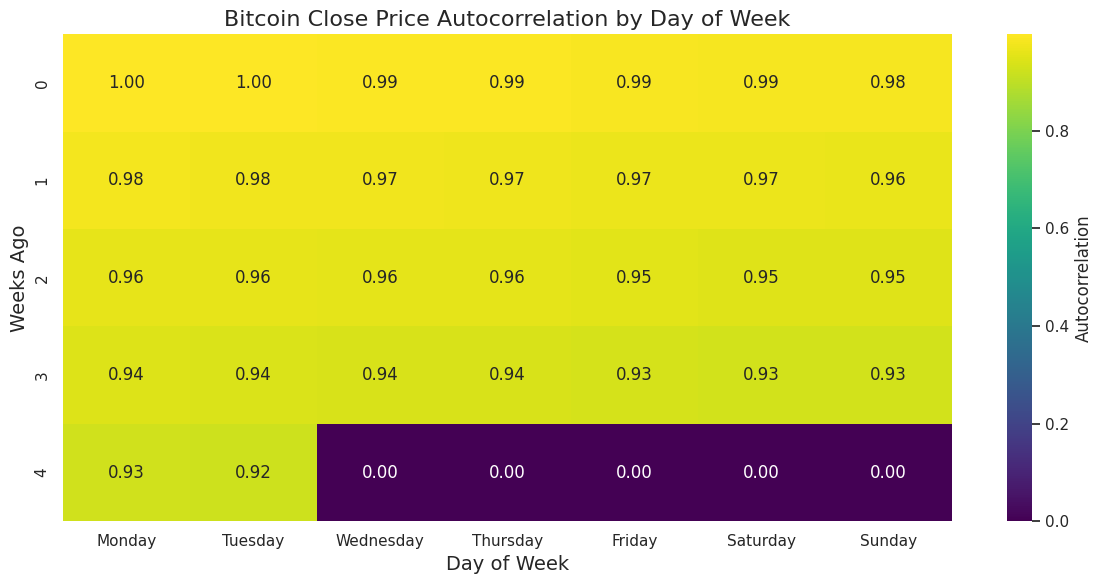

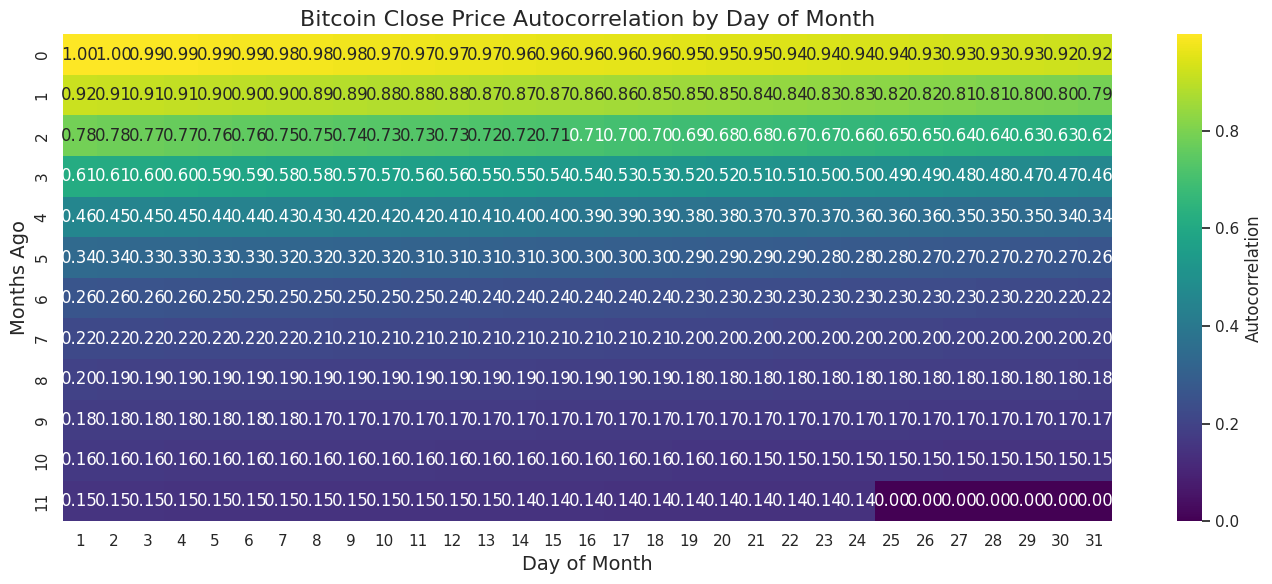

In [20]:
# 📊 Function to plot weekly autocorrelation heatmap (lags grouped by day of week)
def plot_autocorrelation_heatmap(ts_data, target_col, max_lags=30, title="Autocorrelation by Day of Week"):

    # 📉 Calculate autocorrelation values up to max_lags
    acf_values = sm.tsa.acf(ts_data[target_col].values, nlags=max_lags, fft=True)

    # 🗓️ Day labels for the columns of the heatmap
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    n_weeks = max_lags // 7 + 1

    # 🧱 Initialize an empty DataFrame to store weekly autocorrelation values
    acf_df = pd.DataFrame(data=np.zeros((n_weeks, 7)),
                          index=range(n_weeks),
                          columns=days,
                          dtype=float)

    # 🔁 Fill in the heatmap matrix with autocorrelation values mapped to days
    for lag in range(1, max_lags + 1):
        day_idx = (lag - 1) % 7
        week_idx = (lag - 1) // 7
        day_name = days[day_idx]
        acf_df.at[week_idx, day_name] = acf_values[lag]

    # 🔥 Create a heatmap from the weekly autocorrelation DataFrame
    plt.figure(figsize=(12, 6))
    ax = sns.heatmap(acf_df, annot=True, cmap='viridis', fmt='.2f', cbar_kws={'label': 'Autocorrelation'})
    ax.set_title(title, fontsize=16)
    ax.set_ylabel('Weeks Ago', fontsize=14)
    ax.set_xlabel('Day of Week', fontsize=14)
    plt.tight_layout()
    plt.show()

# 🚀 Run the weekly autocorrelation heatmap for Bitcoin
plot_autocorrelation_heatmap(
    ts_data=btc_df,
    target_col='target',
    max_lags=30,
    title='Bitcoin Close Price Autocorrelation by Day of Week'
)



# 📊 Function to plot monthly autocorrelation heatmap (lags grouped by day of month)
def plot_autocorrelation_heatmap_monthly(ts_data, target_col, max_lags=40, title="Autocorrelation by Day of Month"):

    # 📉 Compute ACF values for the given number of lags
    acf_values = sm.tsa.acf(ts_data[target_col].values, nlags=max_lags, fft=True)

    # 🗓️ Days of the month (1 to 31)
    days_in_month = list(range(1, 32))
    n_months = max_lags // 31 + 1

    # 🧱 Create a matrix to hold autocorrelation values
    acf_df = pd.DataFrame(data=np.zeros((n_months, 31)),
                          index=range(n_months),
                          columns=days_in_month,
                          dtype=float)

    # 🔁 Populate the matrix with autocorrelation values
    for lag in range(1, max_lags + 1):
        day_idx = (lag - 1) % 31
        month_idx = (lag - 1) // 31
        acf_df.at[month_idx, day_idx + 1] = acf_values[lag]

    # 🔥 Plot the monthly autocorrelation heatmap
    plt.figure(figsize=(14, 6))
    ax = sns.heatmap(acf_df, annot=True, cmap='viridis', fmt='.2f', cbar_kws={'label': 'Autocorrelation'})
    ax.set_title(title, fontsize=16)
    ax.set_ylabel('Months Ago', fontsize=14)
    ax.set_xlabel('Day of Month', fontsize=14)
    plt.tight_layout()
    plt.show()

# 🚀 Run the monthly autocorrelation heatmap for Bitcoin (up to 365 days of lags)
plot_autocorrelation_heatmap_monthly(
    ts_data=btc_df,
    target_col='target',
    max_lags=365,
    title='Bitcoin Close Price Autocorrelation by Day of Month'
)


###Time Series Decomposition (30-Day and 7-Day Periods)

🔍 What This Code Does:

This code defines a function that decomposes a time series into its core components—trend, seasonality, and residuals—using an additive model. It is applied twice to Bitcoin’s closing price (target) with two different periodicities:

* 30-day period – captures monthly trends and seasonal effects.

* 7-day period – captures weekly seasonality and short-term variations.

Each decomposition is visualized using a 4-panel subplot to illustrate how Bitcoin prices behave over time and what underlying patterns or anomalies might be present.

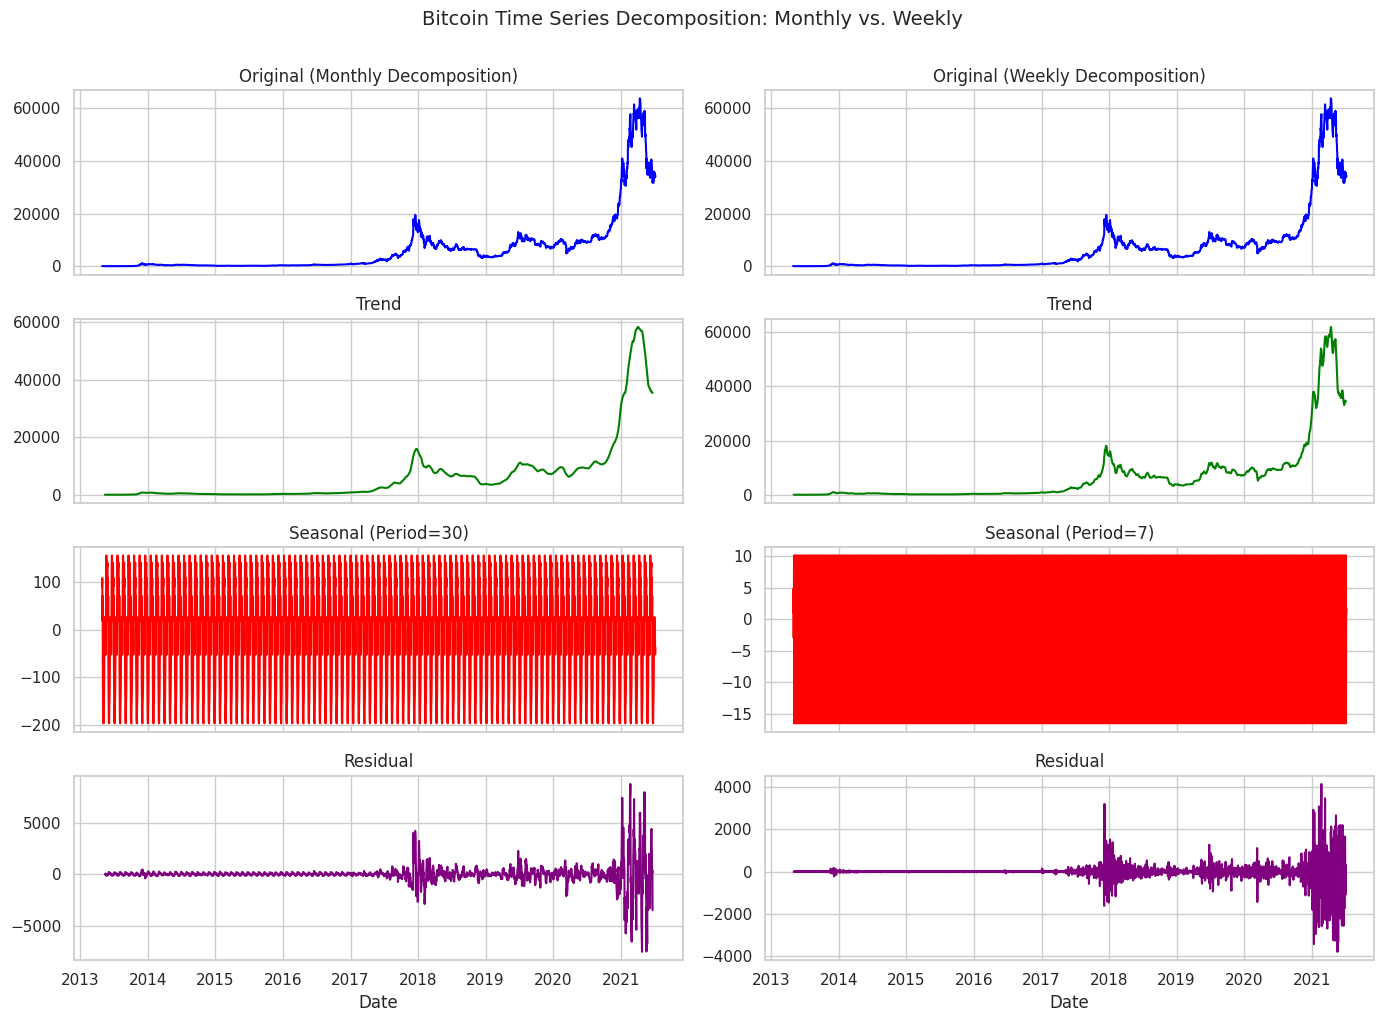

In [21]:


def plot_dual_time_series_decomposition(ts_data, target_col, title1="Monthly Decomposition", title2="Weekly Decomposition", period1=30, period2=7):
    # 🕒 Ensure the DataFrame has a datetime index
    if not isinstance(ts_data.index, pd.DatetimeIndex):
        if 'date' in ts_data.columns:
            ts_data = ts_data.set_index('date')  # 🗓️ Set 'date' column as index
        elif 'Date' in ts_data.columns:
            ts_data = ts_data.set_index('Date')  # 🗓️ Handle case with capital 'Date'
        else:
            raise ValueError("DataFrame must have a datetime index or a 'date' column")  # ❗ Raise error if no valid datetime info

    # 🧮 Perform seasonal decomposition with two different periods
    decomp1 = sm.tsa.seasonal_decompose(ts_data[target_col], model='additive', period=period1)  # 📅 Decompose using monthly period
    decomp2 = sm.tsa.seasonal_decompose(ts_data[target_col], model='additive', period=period2)  # 📆 Decompose using weekly period

    # 🖼️ Set up a 4x2 grid for side-by-side plots
    fig, axes = plt.subplots(4, 2, figsize=(14, 10), sharex=True)

    # 📈 Monthly Decomposition (Left Column)
    axes[0, 0].plot(ts_data.index, ts_data[target_col], color='blue')  # 🔷 Original data
    axes[0, 0].set_title(f'Original ({title1})')

    axes[1, 0].plot(decomp1.trend.index, decomp1.trend, color='green')  # 📉 Trend component
    axes[1, 0].set_title('Trend')

    axes[2, 0].plot(decomp1.seasonal.index, decomp1.seasonal, color='red')  # 🔁 Seasonal component
    axes[2, 0].set_title(f'Seasonal (Period={period1})')

    axes[3, 0].plot(decomp1.resid.index, decomp1.resid, color='purple')  # 🌀 Residuals
    axes[3, 0].set_title('Residual')
    axes[3, 0].set_xlabel('Date')

    # 📈 Weekly Decomposition (Right Column)
    axes[0, 1].plot(ts_data.index, ts_data[target_col], color='blue')  # 🔷 Original data again
    axes[0, 1].set_title(f'Original ({title2})')

    axes[1, 1].plot(decomp2.trend.index, decomp2.trend, color='green')  # 📉 Trend component
    axes[1, 1].set_title('Trend')

    axes[2, 1].plot(decomp2.seasonal.index, decomp2.seasonal, color='red')  # 🔁 Seasonal component
    axes[2, 1].set_title(f'Seasonal (Period={period2})')

    axes[3, 1].plot(decomp2.resid.index, decomp2.resid, color='purple')  # 🌀 Residuals
    axes[3, 1].set_title('Residual')
    axes[3, 1].set_xlabel('Date')

    # 🧽 Clean up the layout for better spacing and title
    plt.suptitle('Bitcoin Time Series Decomposition: Monthly vs. Weekly', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.show()


# ▶️ Run the function on the btc_df DataFrame with specified parameters
plot_dual_time_series_decomposition(
    ts_data=btc_df,
    target_col='target',
    title1='Monthly Decomposition',
    title2='Weekly Decomposition',
    period1=30,
    period2=7
)


##Long Term Forecasting

###Train-Test Split for Forecasting


🔍 What This Code Does:

This block splits the Bitcoin closing price data into a training set and a testing set, using the last 360 days (approximately 1 year) as the test period. It then creates a forecasting horizon and visualizes the split. This is a crucial step for evaluating time series forecasting models using real, unseen data.

Training set: 2631 observations from 2013-04-29 00:00:00 to 2020-07-11 00:00:00
Test set: 360 observations from 2020-07-12 00:00:00 to 2021-07-06 00:00:00


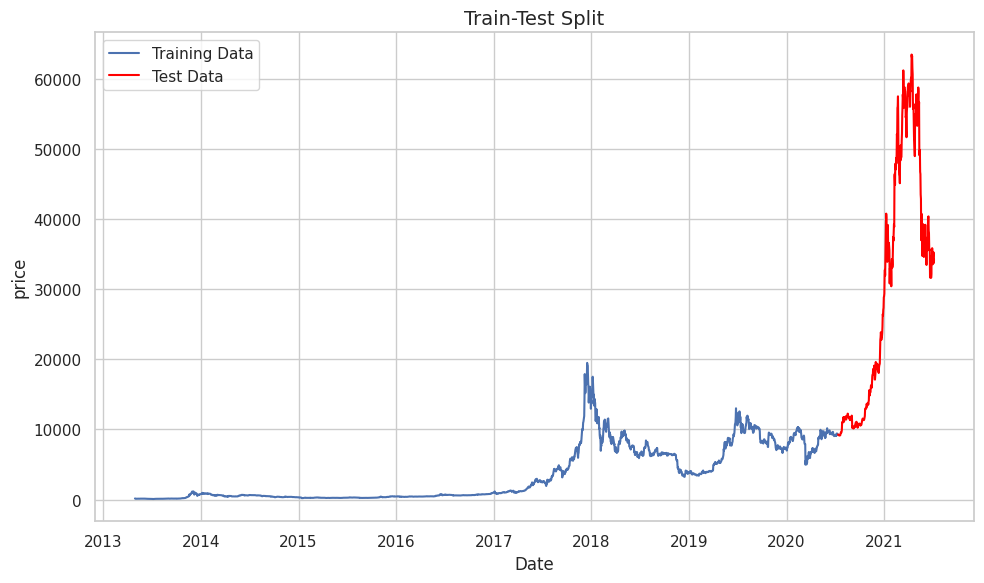

In [22]:
# ✂️ Split data into train and test sets (last 360 days as test)
test_size = 360  # 📆 Approx. 1 year of data
y_train, y_test = temporal_train_test_split(btc_df['target'], test_size=test_size)

# 🖨️ Display the size and date range of each split
print(f"Training set: {len(y_train)} observations from {y_train.index.min()} to {y_train.index.max()}")
print(f"Test set: {len(y_test)} observations from {y_test.index.min()} to {y_test.index.max()}")

# 📍 Create forecasting horizon based on test dates (used for predictions)
fh = ForecastingHorizon(y_test.index, is_relative=False)

# 📈 Plot the training and test set for visual confirmation of the split
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train.values, label='Training Data')
plt.plot(y_test.index, y_test.values, label='Test Data', color='red')
plt.title('Train-Test Split', fontsize=14)
plt.xlabel('Date')
plt.ylabel('price')
plt.legend()
plt.tight_layout()
plt.show()


###Evaluating Forecasting Models with Weekly and Monthly Seasonalities

🔍 What This Code Does:

This block defines and executes a reusable function, evaluate_forecasting_models, to compare the performance of several time series forecasting models on Bitcoin price data using different seasonality settings:

* Monthly seasonality (sp=30)

* Weekly seasonality (sp=7)

For each seasonal setting, the function:

1. Sets daily frequency for both train and test series.

2. Initializes 5 models:

 * Naive

 * Seasonal Naive

 * Exponential Smoothing

 * Polynomial Trend

 * Ensemble (combining Naive and Exponential Smoothing)

3. Trains each model on the training set and forecasts the test set.

4. Evaluates performance using:

 * MAPE (Mean Absolute Percentage Error)

 * RMSE (Root Mean Squared Error)

5. Prints a comparison table and identifies the best-performing model.

6. Visualizes forecasts from all models against the actual data.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.




📊 Evaluation for Monthly Seasonality (sp=30):
                    MAPE        RMSE
Naive             0.5449  27530.9833
Seasonal Naive    0.5426  27478.6732
Exp Smoothing     0.5462  27532.4893
Polynomial Trend  0.4533  25011.4696
Ensemble          0.5455  27531.3349

✅ Best Model: Polynomial Trend

📊 Evaluation for Weekly Seasonality (sp=7):
                    MAPE        RMSE
Naive             0.5449  27530.9833
Seasonal Naive    0.5435  27504.4530
Exp Smoothing     0.5434  27505.4858
Polynomial Trend  0.4533  25011.4696
Ensemble          0.5442  27518.2236

✅ Best Model: Polynomial Trend


<ipython-input-23-afbe0b042293>:65: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

<ipython-input-23-afbe0b042293>:65: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



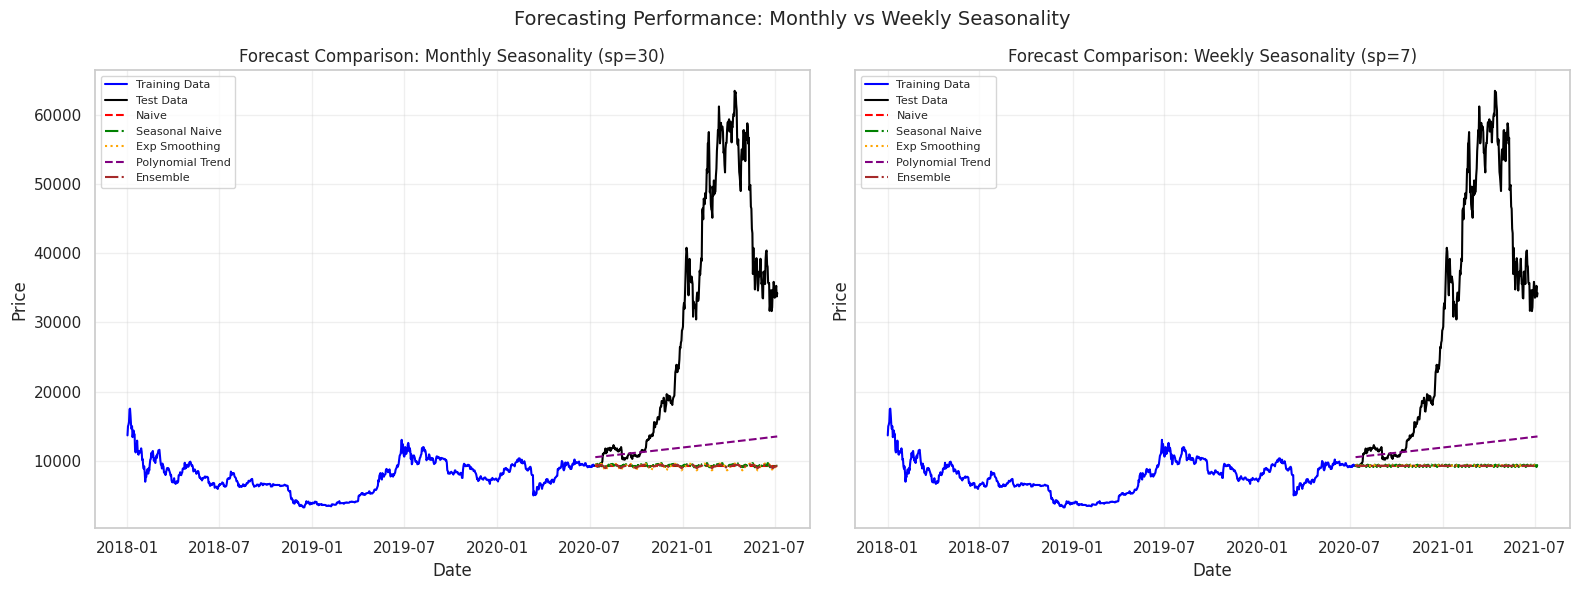

In [23]:
def compare_forecasting_models(y_train, y_test, fh, title_suffix1, sp1, title_suffix2, sp2):
    """
    Evaluate and compare forecasting models with two different seasonal periods.
    Displays side-by-side plots and prints evaluation metrics.
    """

    def get_model_forecasts(y_train, y_test, fh, sp):
        # 🕒 Ensure datetime frequency for time series index
        y_train.index.freq = 'D'
        y_test.index.freq = 'D'

        # 🤖 Define forecasting models
        forecasters = {
            "Naive": NaiveForecaster(strategy="last"),  # 📌 Baseline model: last value
            "Seasonal Naive": NaiveForecaster(strategy="last", sp=sp),  # 🔁 Seasonal pattern
            "Exp Smoothing": ExponentialSmoothing(seasonal="multiplicative", sp=sp),  # 📉 Exponential smoothing with seasonality
            "Polynomial Trend": PolynomialTrendForecaster(degree=2)  # 🧮 Polynomial trend
        }

        # 🧠 Ensemble of Naive and Exponential Smoothing
        forecasters["Ensemble"] = EnsembleForecaster([
            ("naive", forecasters["Naive"]),
            ("theta", forecasters["Exp Smoothing"])
        ])

        results = {}
        for name, forecaster in forecasters.items():
            forecaster.fit(y_train)  # 🧪 Train the model
            y_pred = forecaster.predict(fh)  # 🔮 Forecast into future
            mape = mean_absolute_percentage_error(y_test, y_pred)  # 📉 Calculate MAPE
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # 📏 Calculate RMSE
            results[name] = {
                "forecast": y_pred,
                "mape": mape,
                "rmse": rmse
            }

        # 📋 Create a summary DataFrame of evaluation metrics
        results_df = pd.DataFrame({
            name: {"MAPE": res["mape"], "RMSE": res["rmse"]}
            for name, res in results.items()
        }).T

        # 🏆 Identify the best model by lowest MAPE
        best_model = results_df["MAPE"].idxmin()

        return results, results_df, best_model

    # ⚖️ Evaluate with the first seasonal period (e.g., Monthly)
    results_1, eval_1, best_1 = get_model_forecasts(y_train, y_test, fh, sp1)
    # ⚖️ Evaluate with the second seasonal period (e.g., Weekly)
    results_2, eval_2, best_2 = get_model_forecasts(y_train, y_test, fh, sp2)

    # 🧾 Print evaluation results
    print(f"\n📊 Evaluation for {title_suffix1}:\n{eval_1.round(4)}")
    print(f"\n✅ Best Model: {best_1}")

    print(f"\n📊 Evaluation for {title_suffix2}:\n{eval_2.round(4)}")
    print(f"\n✅ Best Model: {best_2}")

    # 📈 Plot side-by-side comparison of forecasts
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    for ax, results, title in zip(axes, [results_1, results_2], [title_suffix1, title_suffix2]):
        ax.plot(y_train.last("3Y").index, y_train.last("3Y").values, label="Training Data", color="blue")  # 🔵 Training data
        ax.plot(y_test.index, y_test.values, label="Test Data", color="black")  # ⚫ Test data

        colors = ['red', 'green', 'orange', 'purple', 'brown']
        linestyles = ['--', '-.', ':', '--', '-.']

        for i, (name, res) in enumerate(results.items()):
            ax.plot(y_test.index, res["forecast"].values,
                    label=f"{name}", color=colors[i], linestyle=linestyles[i])  # 🔮 Forecast lines

        ax.set_title(f'Forecast Comparison: {title}', fontsize=12)
        ax.set_xlabel("Date")
        ax.set_ylabel("Price")
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

    # 🧽 Final layout and display
    plt.suptitle("Forecasting Performance: Monthly vs Weekly Seasonality", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()


# ▶️ Run the comparison using both seasonality configurations
compare_forecasting_models(
    y_train, y_test, fh,
    title_suffix1="Monthly Seasonality (sp=30)", sp1=30,
    title_suffix2="Weekly Seasonality (sp=7)", sp2=7
)


###Forecasting Future Bitcoin Prices (360 Days Ahead)


🔍 What This Code Does:

This code retrains the best-performing model on the full Bitcoin dataset and uses it to forecast the next 360 days (approximately 12 months). The future predictions are visualized alongside historical data to observe long-term trends.

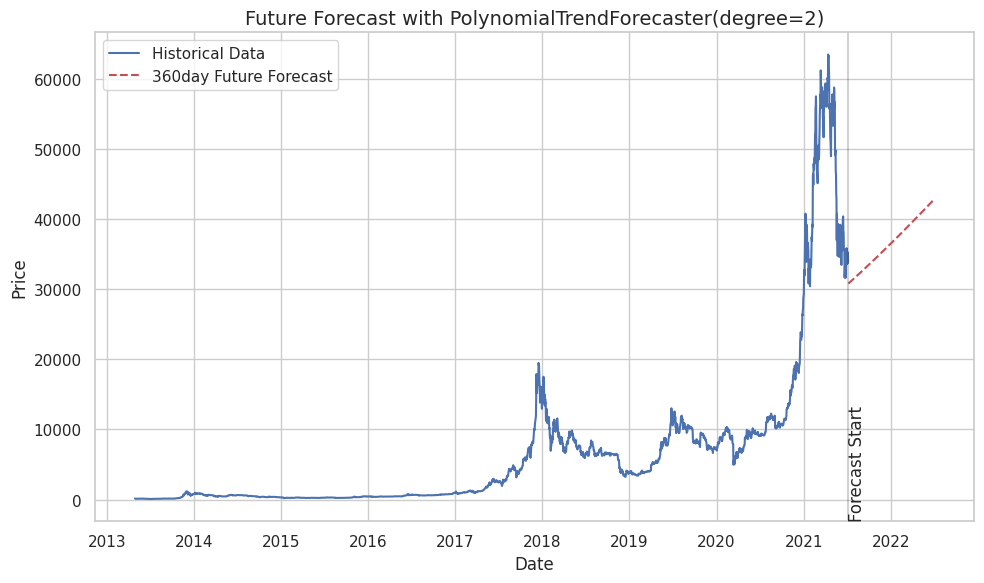

Future Forecast for the next 360 days using PolynomialTrendForecaster(degree=2):
2021-07-07    30815.201436
2021-07-08    30846.032834
2021-07-09    30876.878987
2021-07-10    30907.739893
2021-07-11    30938.615552
                  ...     
2022-06-27    42687.389424
2022-06-28    42723.458345
2022-06-29    42759.542020
2022-06-30    42795.640448
2022-07-01    42831.753629
Freq: D, Name: target, Length: 360, dtype: float64


In [24]:
# 🏆 Retrieve the best model selected earlier based on MAPE
best_model = PolynomialTrendForecaster(degree=2)

# 🔁 Retrain the best model on the full dataset to include all available historical data
best_model.fit(btc_df['target'])

# 📅 Define a future forecasting horizon: next 360 days (1 year of daily data)
future_periods = 360
future_index = pd.date_range(
    start=btc_df.index[-1] + pd.DateOffset(days=1),  # Start from the day after the last known date
    periods=future_periods,
    freq='D'  # Daily frequency
)
future_fh = ForecastingHorizon(future_index, is_relative=False)

# 🔮 Generate the forecast for the future time horizon
future_forecast = best_model.predict(future_fh)

# 📈 Plot both historical and forecasted Bitcoin prices
plt.figure(figsize=(10, 6))

# Plot historical data
plt.plot(btc_df.index, btc_df['target'].values, 'b-', label='Historical Data')

# Plot forecasted future values
plt.plot(future_forecast.index, future_forecast.values, 'r--', label='360day Future Forecast')

# 📍 Add a vertical line marking where the forecast begins
plt.axvline(x=btc_df.index[-1], color='k', linestyle='-', alpha=0.2)
plt.text(btc_df.index[-1], plt.ylim()[0], 'Forecast Start', rotation=90, verticalalignment='bottom')

# 🏷️ Title and axis labels
plt.title(f'Future Forecast with {best_model}', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

# 🖨️ Print the forecasted values for inspection
print(f"Future Forecast for the next {future_periods} days using {best_model}:")
print(future_forecast)


##Short Term Forecasting

###Sliding Window Split (30 days train and 7 days test)

🔍 What This Code Does:

This code demonstrates how to use a sliding window approach to visualize training and testing splits for time series forecasting. It sets up a 30-day training window with a 7-day forecast horizon "using SlidingWindowSplitter from sktime. [4]" The first plot shows this split on the full Bitcoin price series, and the second zooms into a 90-day (3-month) slice to better visualize the train/test split in a shorter period.

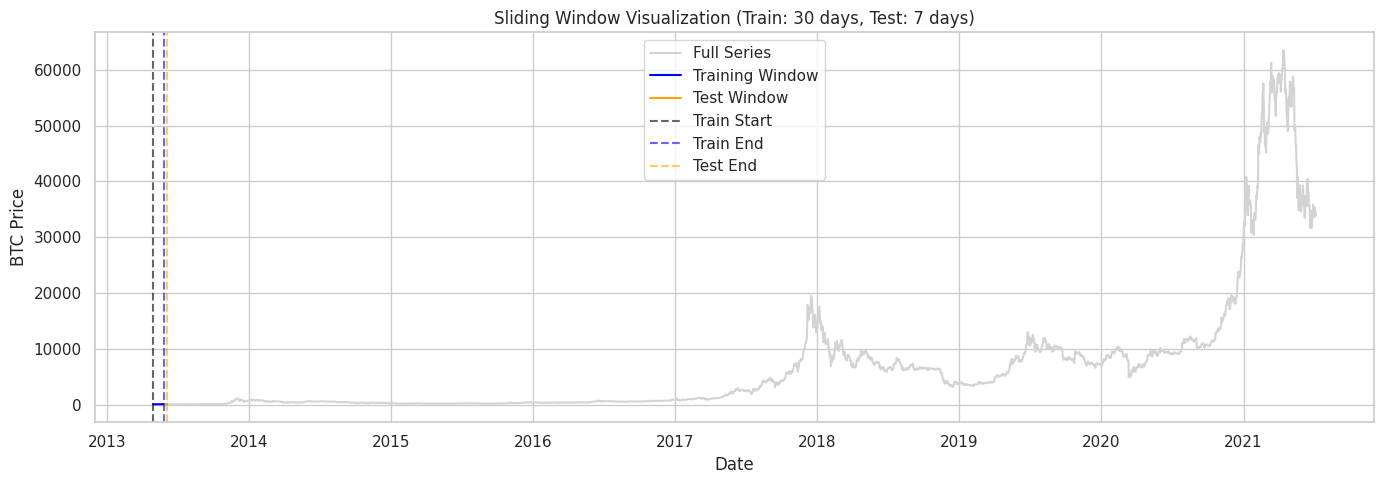

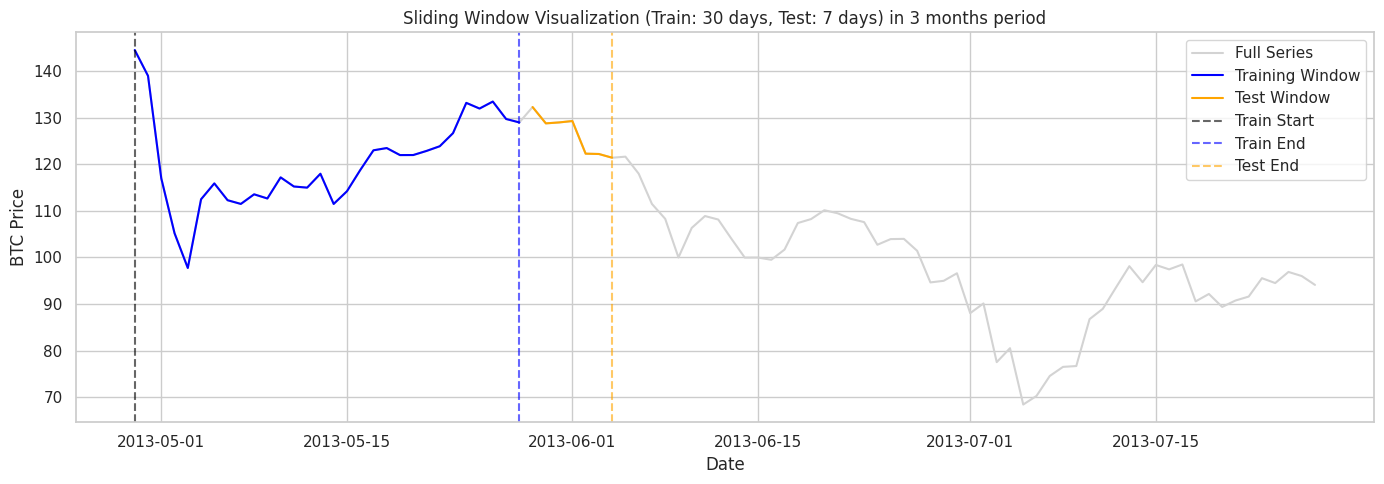

In [25]:


y = btc_df['target']  # 🪙 Select the BTC price target column
# 🗓️ Create dummy BTC price data using index from actual data
date_range = y.index
btc_prices = y

# 🔀 Define a sliding window split (30-day train, 7-day test, step by 7 days)
splitter = SlidingWindowSplitter(
    window_length=30,
    fh=[1, 2, 3, 4, 5, 6, 7],  # 📅 Forecast horizon: 7 days
    step_length=7              # 🔁 Shift window every 7 days
)

# 🔍 Get the first split (train/test indices)
train_idx, test_idx = next(splitter.split(btc_prices))

# 📊 Plot the full series with highlighted training and test windows
plt.figure(figsize=(14, 5))
plt.plot(btc_prices.index, btc_prices.values, color='lightgray', label='Full Series')  # ⚪ Full time series
plt.plot(btc_prices.index[train_idx], btc_prices.values[train_idx], color='blue', label='Training Window')  # 🔵 Train data
plt.plot(btc_prices.index[test_idx], btc_prices.values[test_idx], color='orange', label='Test Window')  # 🟠 Test data

# 📌 Vertical lines to show window boundaries
plt.axvline(x=btc_prices.index[train_idx[0]], color='black', linestyle='--', alpha=0.6, label='Train Start')  # ⬅️ Train start
plt.axvline(x=btc_prices.index[train_idx[-1]], color='blue', linestyle='--', alpha=0.6, label='Train End')    # ➡️ Train end
plt.axvline(x=btc_prices.index[test_idx[-1]], color='orange', linestyle='--', alpha=0.6, label='Test End')    # ⏹️ Test end

plt.title('Sliding Window Visualization (Train: 30 days, Test: 7 days)')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend()
plt.tight_layout()
plt.show()

# 🗂️ Repeat for a 3-month subset (first 90 days)
y = btc_df['target']

date_range = y.index
btc_prices = y.iloc[:90]  # 📏 Slice first 90 days of data

# 📊 Plot again for zoomed-in view
plt.figure(figsize=(14, 5))
plt.plot(btc_prices.index, btc_prices.values, color='lightgray', label='Full Series')  # ⚪ Full time series
plt.plot(btc_prices.index[train_idx], btc_prices.values[train_idx], color='blue', label='Training Window')  # 🔵 Train data
plt.plot(btc_prices.index[test_idx], btc_prices.values[test_idx], color='orange', label='Test Window')  # 🟠 Test data

# 📌 Vertical lines for boundaries again
plt.axvline(x=btc_prices.index[train_idx[0]], color='black', linestyle='--', alpha=0.6, label='Train Start')  # ⬅️ Train start
plt.axvline(x=btc_prices.index[train_idx[-1]], color='blue', linestyle='--', alpha=0.6, label='Train End')    # ➡️ Train end
plt.axvline(x=btc_prices.index[test_idx[-1]], color='orange', linestyle='--', alpha=0.6, label='Test End')    # ⏹️ Test end

plt.title('Sliding Window Visualization (Train: 30 days, Test: 7 days) in 3 months period')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend()
plt.tight_layout()
plt.show()


###Evaluating Model Stability Using Sliding Window Cross-Validation

🔍 What This Code Does:

This block applies sliding window cross-validation to assess how well each forecasting model performs over multiple time intervals, rather than on a single train-test split. It computes the Mean Absolute Percentage Error (MAPE) for each model across all windows, then reports the average MAPE to identify the most stable and consistent model over time.

In [26]:
# 🎯 Set the target time series for evaluation (daily BTC closing price)
y = btc_df['target']

# 🔁 Configure a sliding window cross-validation scheme
splitter = SlidingWindowSplitter(
    window_length=30,      # Use 30 days for training in each split
    fh=[1,2,3,4,5,6,7],     # Forecast the next 7 days in each split
    step_length=7          # Move the window 7 days forward for each split
)

# 📦 Define a set of simple forecasting models to compare
models = {
    "Naive": NaiveForecaster(strategy="last"),
    "Seasonal Naive": NaiveForecaster(strategy="last", sp=7),
    "Exponential Smoothing": ExponentialSmoothing(seasonal="multiplicative", sp=7),
    "Polynomial Trend": PolynomialTrendForecaster(degree=2)
}

# 📊 Prepare a dictionary to collect MAPE scores per model per window
model_mape_results = {name: [] for name in models}

# 🔄 Loop through each sliding window split
for i, (train_idx, test_idx) in enumerate(splitter.split(y), 1):
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    fh = ForecastingHorizon(y_test.index, is_relative=False)

    # ✅ Ensure frequency is explicitly set
    y_train.index.freq = 'D'
    y_test.index.freq = 'D'

    # 🚀 Train and evaluate each model on the current split
    for name, forecaster in models.items():
        try:
            forecaster.fit(y_train)
            y_pred = forecaster.predict(fh)
            mape = mean_absolute_percentage_error(y_test, y_pred)

            # 💾 Store MAPE score
            model_mape_results[name].append(mape)

        except Exception as e:
            # ❗ If model fails, append NaN to keep index alignment
            model_mape_results[name].append(np.nan)

# 📐 Convert results into a DataFrame for easier analysis
mape_df = pd.DataFrame(model_mape_results)

# 📉 Calculate and print the average MAPE per model across all splits
avg_mape = mape_df.mean().sort_values()
print("\n📉 Average MAPE per model:")
print(avg_mape)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwint


📉 Average MAPE per model:
Naive                    0.058293
Exponential Smoothing    0.061463
Seasonal Naive           0.080159
Polynomial Trend         0.091929
dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



###Evaluate Exponential Smoothing Model for BTC Using Slidding Window Cross-Validation

🔍 What This Code Does:

This code evaluates an Exponential Smoothing forecasting model using sliding window cross-validation over Bitcoin price data. It trains on 30-day windows, predicts the next 7 days, and repeats for 10 splits (otherwise it will run for a long time). For each split, it computes the Mean Absolute Percentage Error (MAPE), prints the results, and visualizes the forecast compared to actual values.


🔁 Split 1:
MAPE: 0.0476
                Actual   Predicted
2013-05-29  132.300003  124.501181
2013-05-30  128.798996  123.846946
2013-05-31  129.000000  126.991224
2013-06-01  129.300003  130.210772
2013-06-02  122.292000  131.735189
2013-06-03  122.222000  131.182342
2013-06-04  121.419998  129.000000


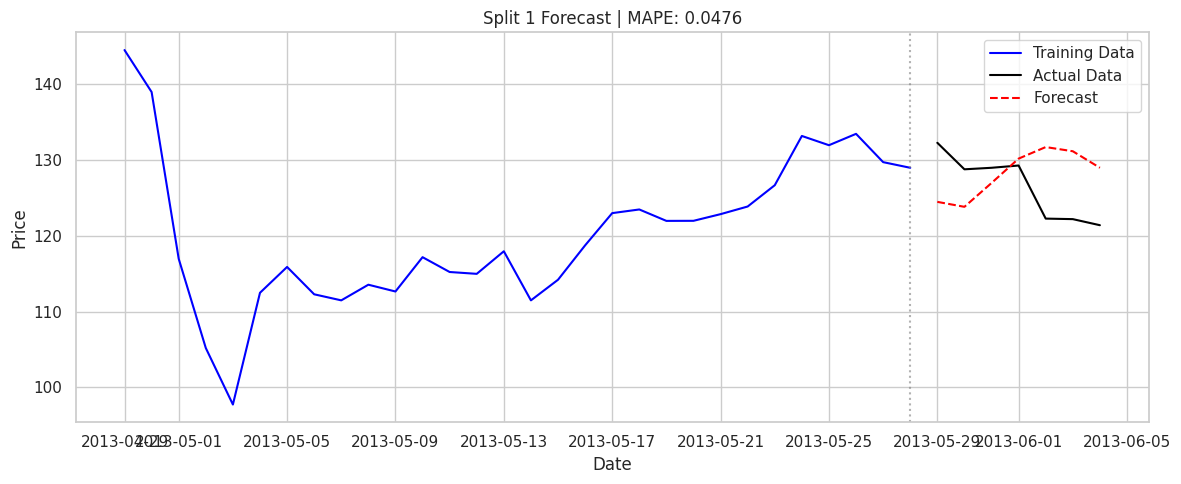


🔁 Split 2:
MAPE: 0.1247
                Actual   Predicted
2013-06-05  121.650002  123.214052
2013-06-06  118.000000  123.477781
2013-06-07  111.500000  127.007271
2013-06-08  108.300003  126.072932
2013-06-09  100.000000  123.861328
2013-06-10  106.349998  123.159893
2013-06-11  108.900002  121.284650


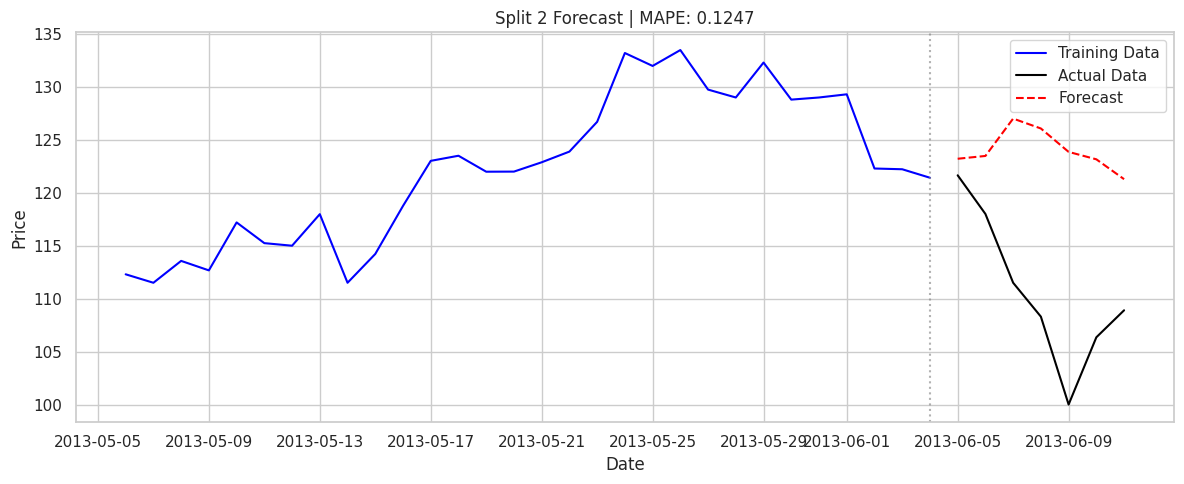


🔁 Split 3:
MAPE: 0.0747
                Actual   Predicted
2013-06-12  108.150002  110.826005
2013-06-13  104.000000  111.050971
2013-06-14   99.978897  112.423225
2013-06-15   99.988098  111.957607
2013-06-16   99.510002  108.981109
2013-06-17  101.699997  109.533492
2013-06-18  107.400002  108.900001


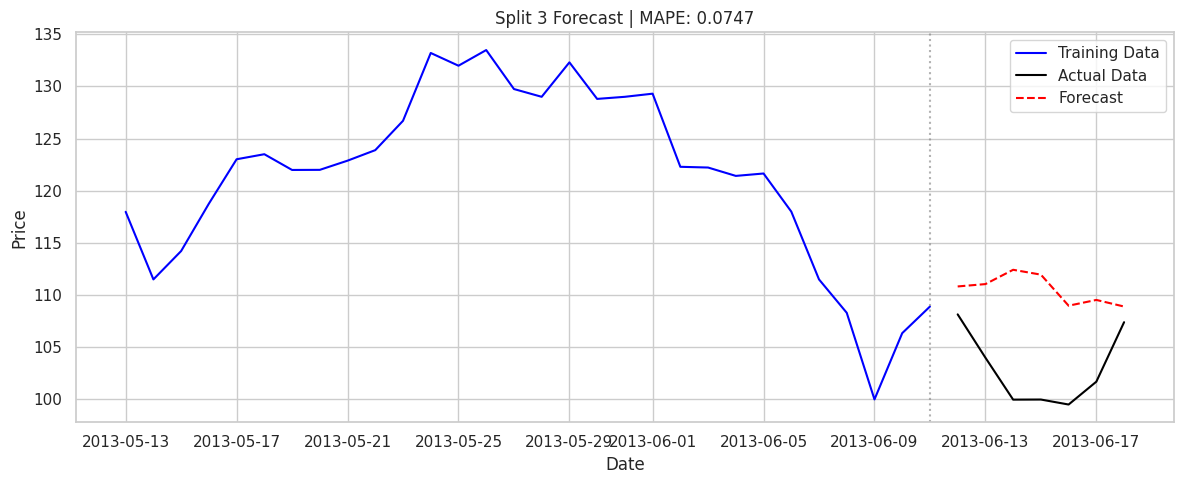


🔁 Split 4:
MAPE: 0.0215
                Actual   Predicted
2013-06-19  108.250000  108.844760
2013-06-20  110.150002  107.540030
2013-06-21  109.500000  107.459897
2013-06-22  108.300003  107.108276
2013-06-23  107.599998  104.510839
2013-06-24  102.737000  105.771273
2013-06-25  103.949997  107.400001


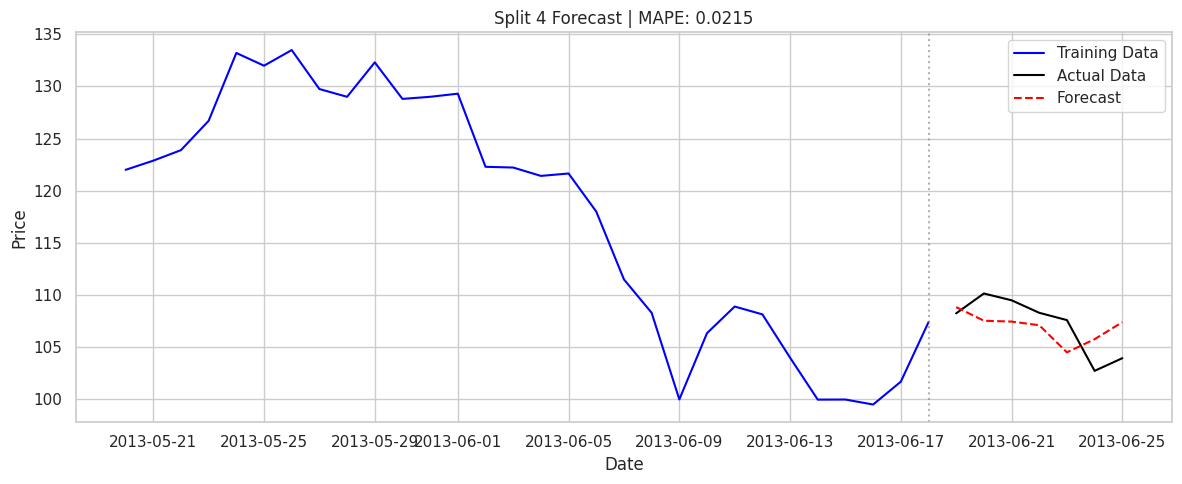


🔁 Split 5:
MAPE: 0.0814
                Actual   Predicted
2013-06-26  104.000000  105.741353
2013-06-27  101.436996  104.497201
2013-06-28   94.649200  103.060412
2013-06-29   94.994003  103.141276
2013-06-30   96.613998  100.211320
2013-07-01   88.050003  101.941791
2013-07-02   90.134003  103.949997


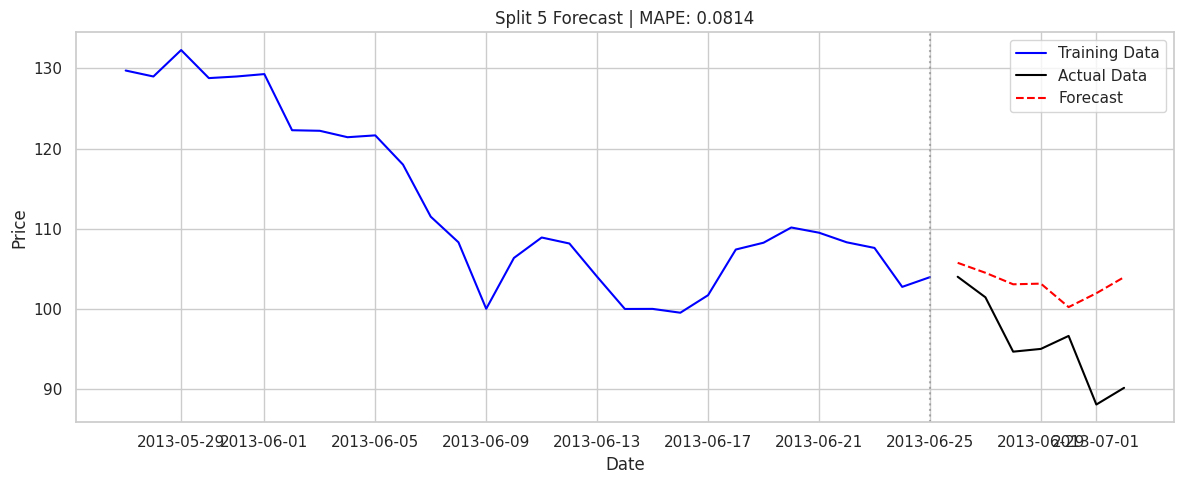


🔁 Split 6:
MAPE: 0.1901
               Actual  Predicted
2013-07-03  77.529999  91.229137
2013-07-04  80.525803  90.502368
2013-07-05  68.431000  87.873418
2013-07-06  70.277298  88.081447
2013-07-07  74.561096  87.447108
2013-07-08  76.515999  87.575792
2013-07-09  76.694000  90.134003


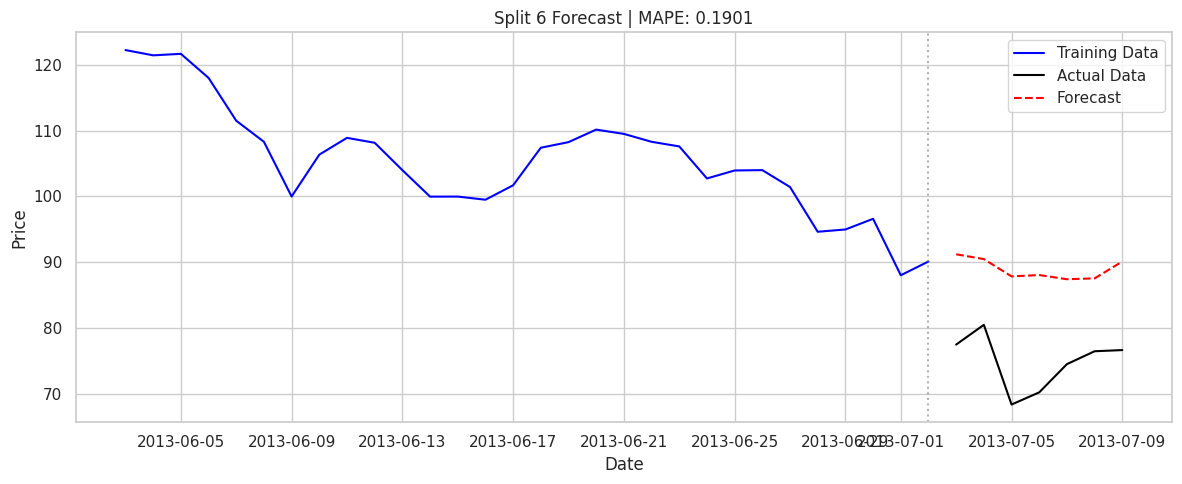


🔁 Split 7:
MAPE: 0.2022
               Actual  Predicted
2013-07-10  86.760002  75.531414
2013-07-11  88.980003  75.858606
2013-07-12  93.594902  72.651064
2013-07-13  98.133904  73.619908
2013-07-14  94.691299  75.213760
2013-07-15  98.400200  74.123784
2013-07-16  97.450798  76.727015


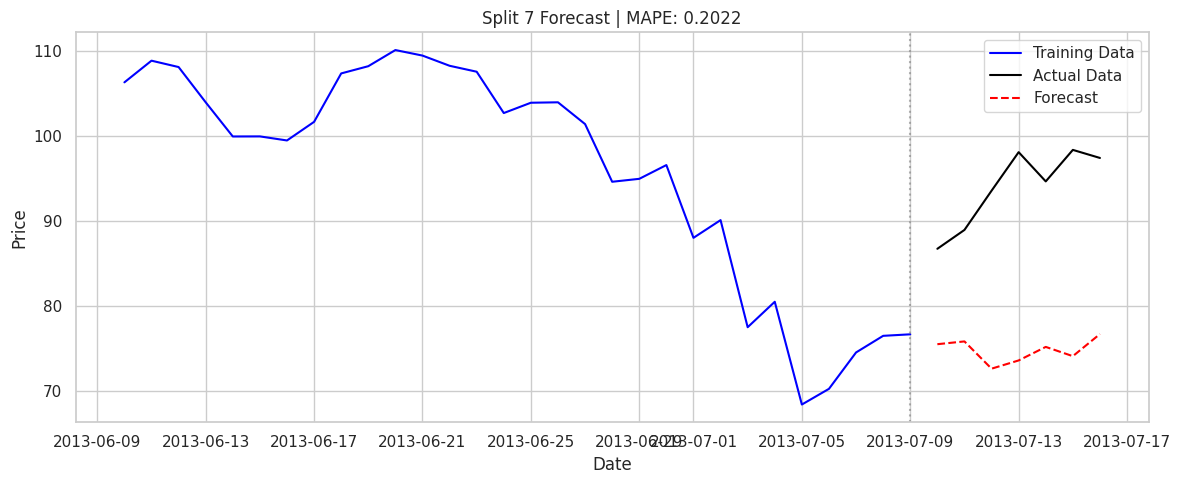


🔁 Split 8:
MAPE: 0.0516
               Actual  Predicted
2013-07-17  98.500000  97.248581
2013-07-18  90.580002  98.612025
2013-07-19  92.169998  95.435009
2013-07-20  89.390099  97.071342
2013-07-21  90.757301  97.552004
2013-07-22  91.610001  95.535847
2013-07-23  95.558502  97.574415


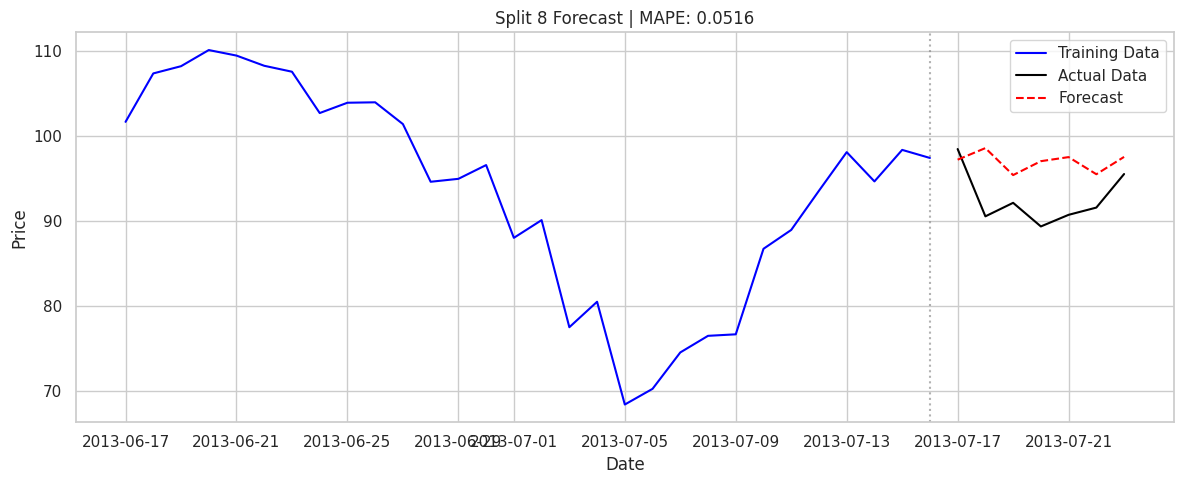


🔁 Split 9:
MAPE: 0.0505
                Actual  Predicted
2013-07-24   94.510002  95.028058
2013-07-25   96.900002  93.832175
2013-07-26   96.020203  91.180191
2013-07-27   94.115997  92.674793
2013-07-28   99.755997  93.871909
2013-07-29  101.199997  93.645656
2013-07-30  107.989998  95.335627


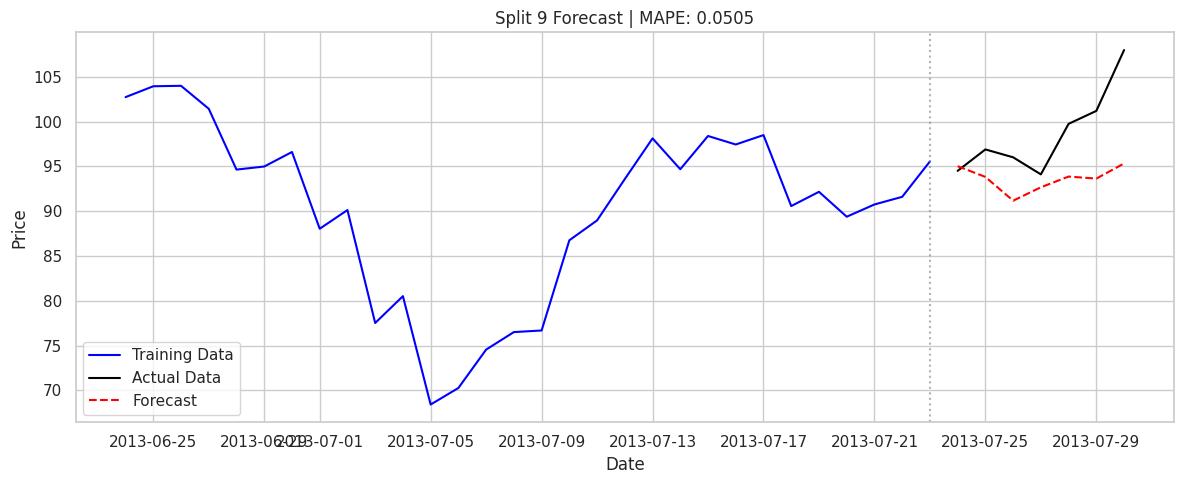


🔁 Split 10:
MAPE: 0.0126
                Actual   Predicted
2013-07-31  106.089996  105.400521
2013-08-01  104.000000  104.418889
2013-08-02  104.500999  102.136075
2013-08-03  104.004997  101.917623
2013-08-04  105.143997  103.309747
2013-08-05  106.220001  105.027444
2013-08-06  106.750000  107.441766


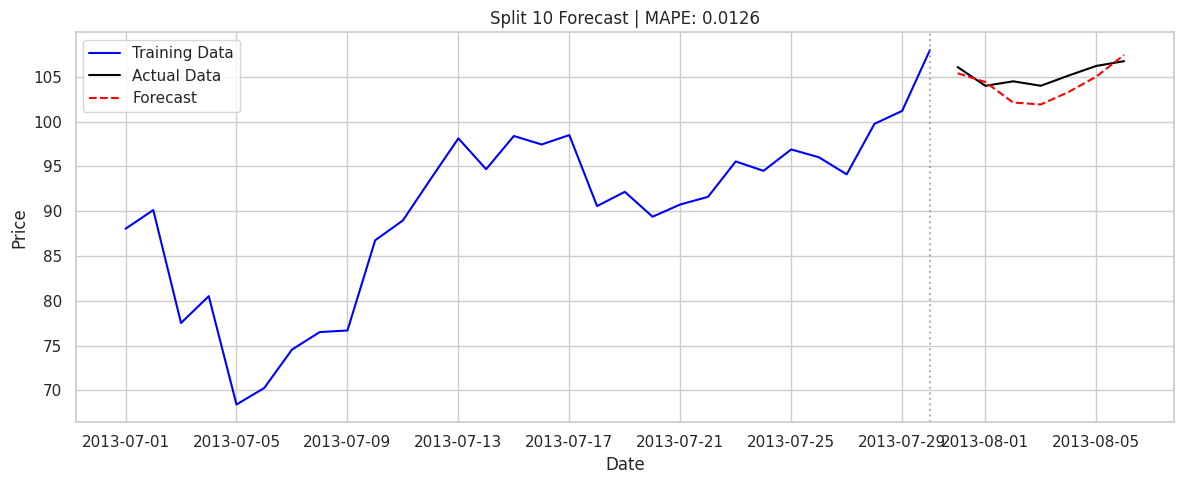

In [29]:
# 🎯 Set the target time series for evaluation (daily BTC closing price)
y = btc_df['target']
y.index.freq = 'D'  # ✅ Ensure the frequency is set to daily

# 🔁 Configure a sliding window cross-validation scheme
splitter = SlidingWindowSplitter(
    window_length=30,      # Use 30 days for training in each split
    fh=[1, 2, 3, 4, 5, 6, 7],  # Forecast the next 7 days in each split
    step_length=7          # Move the window forward by 7 days after each split
)

# 🔧 Define the model to be evaluated
forecaster = ExponentialSmoothing(seasonal="multiplicative", sp=7)

# 📊 Prepare a list to collect MAPE scores from each split
mape_scores = []

# 🔄 Loop through each split defined by the sliding window
for i, (train_idx, test_idx) in enumerate(splitter.split(y), 1):
    if i == 11:# 🚪 Stop after 10 iterations
      break
    # 📦 Extract training and testing slices
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    fh = ForecastingHorizon(y_test.index, is_relative=False)

    # ✅ Fit the model on the training data
    forecaster.fit(y_train)

    # 📈 Predict the test horizon
    y_pred = forecaster.predict(fh)

    # 📏 Calculate MAPE for this split and store it
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mape_scores.append(mape)

    # 🧮 Create a comparison DataFrame for actual vs. predicted
    comparison = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred
    })

    # 🖨️ Print metrics and sample output
    print(f"\n🔁 Split {i}:")
    print(f"MAPE: {mape:.4f}")
    print(comparison.head(10))  # Display first 10 predictions for quick check

    # 📊 Visualize training, actual, and predicted values
    plt.figure(figsize=(12, 5))
    plt.plot(y_train.index, y_train, label='Training Data', color='blue')
    plt.plot(y_test.index, y_test, label='Actual Data', color='black')
    plt.plot(y_pred.index, y_pred, label='Forecast', color='red', linestyle='--')

    # 🔲 Mark the split point visually
    plt.axvline(x=y_train.index[-1], color='gray', linestyle=':', alpha=0.6)
    plt.title(f'Split {i} Forecast | MAPE: {mape:.4f}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.show()


###Short-Term Forecasting (7 Days Ahead)

🔍 What This Code Does:

This code fits the best-performing forecasting model (Exponential Smoothing with weekly seasonality) to the entire Bitcoin price dataset, generates a 7-day forecast beyond the last known date, visualizes the result, and prints the forecasted values. A vertical marker indicates the start of the forecast period on the plot.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



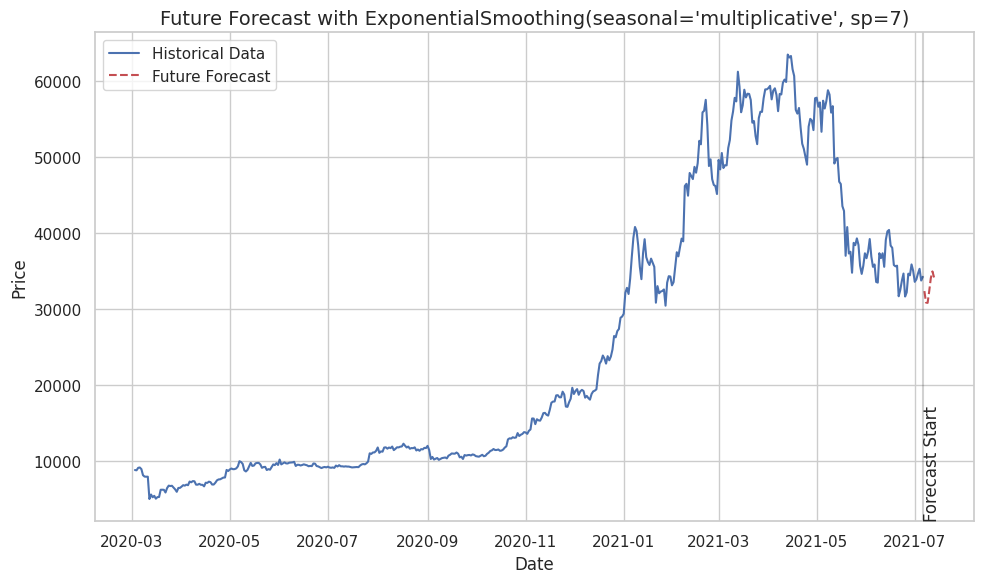

Future Forecast for the next 7 days using ExponentialSmoothing(seasonal='multiplicative', sp=7):
2021-07-07    32352.158220
2021-07-08    30844.201737
2021-07-09    30801.022632
2021-07-10    32352.977447
2021-07-11    34072.891191
2021-07-12    34945.255271
2021-07-13    34152.076345
Freq: D, Name: target, dtype: float64


In [28]:
# 📦 Select and initialize the best-performing model
best_model = ExponentialSmoothing(seasonal="multiplicative", sp=7)

# 🎯 Define the complete time series for training
y = btc_df['target']

# ✅ Fit the model to the entire dataset
best_model.fit(y)

# 🔮 Define the forecast horizon (next 7 days)
future_periods = 7
future_index = pd.date_range(
    start=y.index[-1] + pd.DateOffset(days=1),  # Start day after the last known date
    periods=future_periods,
    freq='D'
)
future_fh = ForecastingHorizon(future_index, is_relative=False)

# 📈 Generate the forecast for the defined horizon
future_forecast = best_model.predict(future_fh)

# 📊 Plot the historical data and forecast
plt.figure(figsize=(10, 6))
plt.plot(y.index[2500:], y.values[2500:], 'b-', label='Historical Data')  # Plot subset of historical data for clarity
plt.plot(future_forecast.index, future_forecast.values, 'r--', label='Future Forecast')

# 🔲 Add visual marker for forecast start
plt.axvline(x=y.index[-1], color='k', linestyle='-', alpha=0.2)
plt.text(y.index[-1], plt.ylim()[0], 'Forecast Start', rotation=90, verticalalignment='bottom')

plt.title(f'Future Forecast with {best_model}', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

# 🖨️ Display forecasted values
print(f"Future Forecast for the next {future_periods} days using {best_model}:")
print(future_forecast)


# Reference list:

[1] R. K. Rathore, D. Mishra, P. S. Mehra, O. Pal, A. S. Hashim, A. Shapi'i, T. Ciano, and M. Shutaywi, "Real-world model for bitcoin price prediction," Information Processing & Management, vol. 59, no. 4, 2022, Art. no. 102968. DOI: 10.1016/j.ipm.2022.102968. [Online]. Available: https://www.sciencedirect.com/science/article/pii/S030645732200084X.

[2] The Cryptocurrency Historical Dataset: https://www.kaggle.com/datasets/sudalairajkumar/cryptocurrencypricehistory

[3] J. Liu and A. Serletis, "Volatility in the Cryptocurrency Market," Open Economies Review, vol. 30, no. 4, pp. 779–811, 2019. DOI: 10.1007/s11079-019-09547-5. [Online]. Available: https://link.springer.com/article/10.1007/s11079-019-09547-5.

[4] sktime Developers, "SlidingWindowSplitter — sktime documentation," sktime, Version 0.21.0, [Online]. Available: https://www.sktime.net/en/v0.21.0/api_reference/auto_generated/sktime.forecasting.model_selection.SlidingWindowSplitter.html.